In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.api import ExponentialSmoothing, SimpleExpSmoothing
from statsmodels.tsa.holtwinters import Holt, HoltWintersResults,HoltWintersResultsWrapper
from pmdarima.arima import auto_arima
from pmdarima.arima.stationarity import ADFTest
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.stattools import kpss
from sklearn.metrics import mean_squared_error
from math import sqrt
from sklearn.model_selection import train_test_split
import datetime
import statsmodels.api as sm

In [2]:
us_confirmed = pd.read_csv("C:/Users/aparna/gitRepos/data/JHU/COVID-19/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_confirmed_US.csv")
us_dead = pd.read_csv("C:/Users/aparna/gitRepos/data/JHU/COVID-19/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_deaths_US.csv")
global_confirmed = pd.read_csv("C:/Users/aparna/gitRepos/data/JHU/COVID-19/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_confirmed_global.csv")
global_dead = pd.read_csv("C:/Users/aparna/gitRepos/data/JHU/COVID-19/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_deaths_global.csv")
global_recovered = pd.read_csv("C:/Users/aparna/gitRepos/data/JHU/COVID-19/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_recovered_global.csv")

In [3]:
global_confirmed = global_confirmed.reset_index()
global_dead = global_dead.reset_index()

In [4]:
def get_region_confirmed(admin, ps, cntry,debug=False):
    row_index_start = 0
    if(not cntry):
        print("At the highest level of summarization, it cannot be empty")
        return
    if(cntry == "US"):
        row_index_start = 11
        if (not ps and not admin):
            us_region_data = global_confirmed[(global_confirmed['Country/Region']==cntry)]
            row_index_start = 6
        elif (not admin):
            row_index_start = 11
            state_province = us_confirmed[(us_confirmed["Country_Region"]=="US") & (us_confirmed["Province_State"]==ps)]
            state_province_total = state_province.sum()[row_index_start:]
            df = pd.DataFrame(data=state_province_total.values, index=state_province_total.index.array, columns=["value"])
            df_new = df.reset_index().rename(columns={'index': 'variable'})
            if debug:
                print(df_new)
                print(df_new.describe())
            return df_new
        else:
            us_region_data = us_confirmed[(us_confirmed['Admin2']==admin) & (us_confirmed['Province_State']==ps) & (us_confirmed['Country_Region']==cntry)]
        if debug:
            print(us_region_data)
        return pd.melt(us_region_data)[row_index_start:]
    else:
        if (not ps):
            row_index_start = 6
            region_data = global_confirmed[(global_confirmed['Country/Region']==cntry)]
            region_data_sum = region_data.sum()[row_index_start:]
            df = pd.DataFrame(data=region_data_sum.values, index=region_data_sum.index.array, columns=["value"])
            df_new = df.reset_index().rename(columns={'index': 'variable'})
            return df_new
        else:
            row_index_start = 6
            region_data = global_confirmed[(global_confirmed['Province/State']==ps) & (global_confirmed['Country/Region']==cntry)]
        return pd.melt(region_data)[row_index_start:]

In [5]:
def plot_region_confirmed(admin=None, ps=None, cntry=None,freq=1,debug=False):
    zap = get_region_confirmed(admin,ps,cntry,debug)
    if(debug):
        print(zap)
    if (freq > 1):
        zap = zap.iloc[::freq,]
    plt.xticks(rotation=30)
    plt.plot(zap['variable'],zap['value'])
    plt.show()

In [6]:
def getStartDate(dataFrame):
    return dataFrame["variable"].iloc[0]
   
def getEndDate(dataFrame):  
    return dataFrame["variable"].iloc[-1]

In [7]:
def getSeriesFromDataFrame(dataFrame, startDate="1/22/20",endDate = "5/14/20"):
    data = dataFrame['value'].to_numpy().astype(int)
    index = pd.date_range(start=startDate,end=endDate,freq="D")
    return pd.Series(data, index)

def getDifferenceOfSeriesFromDataFrame(dataFrame, startDate="1/22/20",endDate = "5/14/20"):
    data = dataFrame['value'].to_numpy().astype(int)
    data1 = [data[i + 1] - data[i] for i in range(len(data)-1)] 
    data1.insert(0,data[0])
    index = pd.date_range(start=startDate,end=endDate,freq="D")
    return pd.Series(data1, index)

def plotDeathToll(dataSeries, regionName):
    ax = dataSeries.plot()
    ax.set_xlabel("Date")
    ax.set_ylabel("Covid death toll")
    plt.show()
    print("Death toll in", regionName)
    
def plotSeasonalDecompositionFromDataframe(dataFrame):
    result = seasonal_decompose(dataFrame['value'].values,  model ='additive', freq=1) 
    result.plot()
    
def plotSeasonalDecompositionFromDataSeries(dataSeries):
    result = seasonal_decompose(dataSeries.to_numpy().astype(int),  model ='additive', freq=1) 
    result.plot()

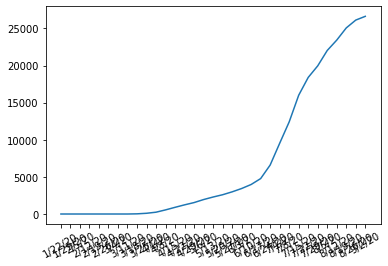

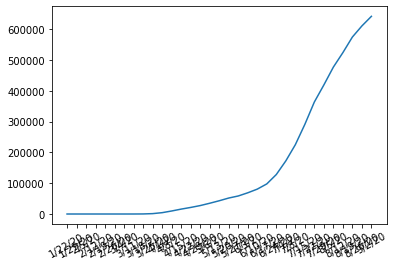

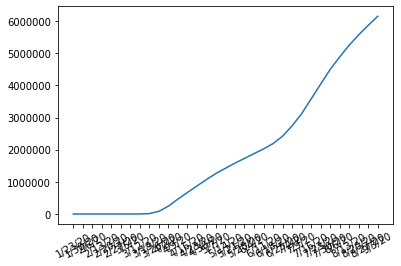

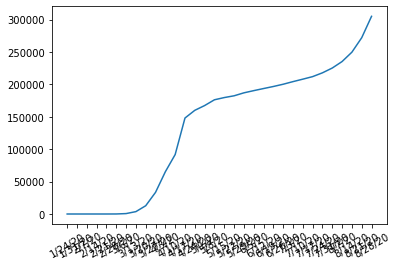

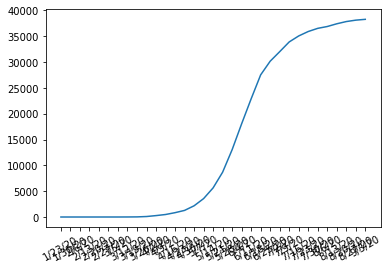

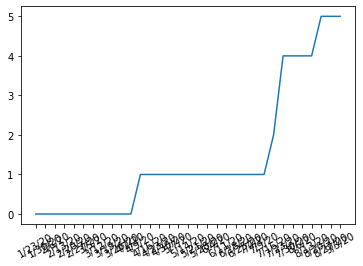

In [8]:
#can get county level data in us
plot_region_confirmed("Travis","Texas","US",7)
#can get state level data in us
plot_region_confirmed(ps="Texas",cntry="US",freq=7)
#can get country level data in us
plot_region_confirmed(cntry="US",freq=7)
#can get global country level confirmed cases in country with provinces
plot_region_confirmed(cntry="France",freq=7)
#can get global country level confirmed cases
plot_region_confirmed(cntry="Afghanistan",freq=7)
# can get global province level data
plot_region_confirmed(ps="Saint Pierre and Miquelon",cntry="France",freq=7)

In [9]:
def get_region_dead(admin=None, ps=None, cntry=None,debug=False):
    row_start_index = 0
    if not cntry:
        print("Need to at least provide country level of summarization")
        return
    if (cntry == "US"):
        if ps and admin:
            row_start_index = 12
            dead_count = us_dead[(us_dead["Admin2"] == admin) & (us_dead["Province_State"] == ps) & (us_dead["Country_Region"] == cntry)]
        elif ps:
            row_index_start = 12
            dead_count = us_dead[(us_dead["Province_State"] == ps) & (us_dead["Country_Region"] == cntry)]
            dead_count_sum = dead_count.sum()[row_index_start:]
            df = pd.DataFrame(data=dead_count_sum.values, index=dead_count_sum.index.array, columns=["value"])
            df_new = df.reset_index().rename(columns={'index': 'variable'})
            if debug:
                print(df_new)
            return df_new
        else:
            row_start_index = 5
            dead_count = global_dead[(global_dead["Country/Region"] == "US")]
    else:
        row_start_index = 5
        if ps:
            dead_count = global_dead[ (global_dead["Province/State"] == ps) & (global_dead["Country/Region"] == cntry)]
        else:
            dead_count = global_dead[(global_dead["Country/Region"] == cntry)]
            dead_count_sum = dead_count.sum()[row_start_index:]
            df = pd.DataFrame(data = dead_count_sum.values, index = dead_count_sum.index.array, columns=["value"])
            df_new = df.reset_index().rename(columns={'index': 'variable'})
            if debug:
                print(df_new)
            return df_new
    if debug:
        print(dead_count)
    
    return pd.melt(dead_count)[row_start_index:]

In [10]:
def plot_region_dead(admin=None, ps=None, cntry=None,debug=False, freq = 1, title = "Default"):
    dead = get_region_dead(admin, ps, cntry, debug)
    if (freq > 1):
        dead = dead.iloc[::freq,]
    plt.xticks(rotation=30)
    plt.title(title)
    plt.plot(dead['variable'],dead['value'])
    plt.show()

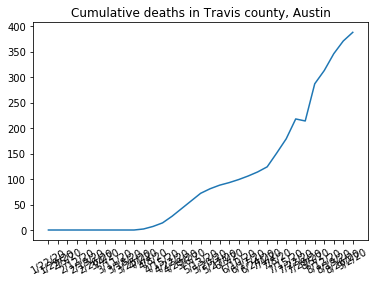

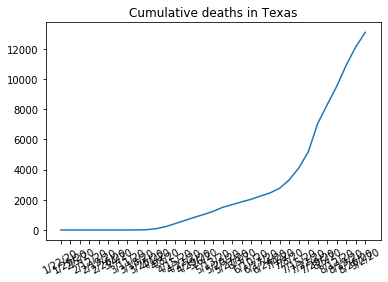

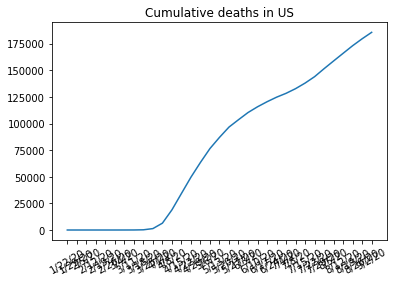

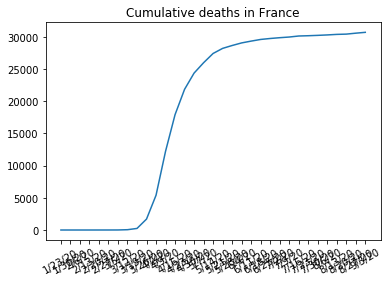

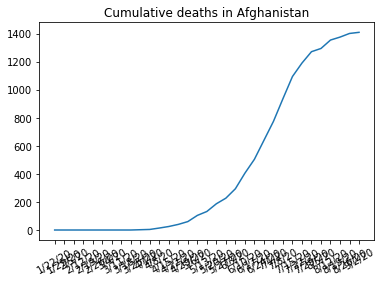

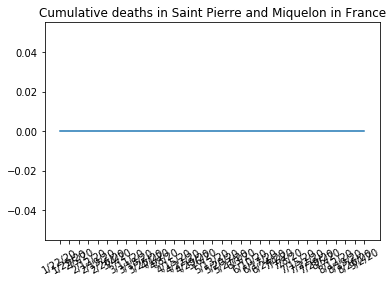

In [11]:
#plot county level dead in US
plot_region_dead(admin="Travis",ps="Texas",cntry="US",debug = False,freq=7, title="Cumulative deaths in Travis county, Austin")
#plot state level dead in US
plot_region_dead(ps="Texas",cntry="US",debug = False,freq=7,title="Cumulative deaths in Texas")
#plot country level dead in US
plot_region_dead(cntry="US",debug = False,freq=7, title="Cumulative deaths in US")
#plot global country level dead
plot_region_dead(cntry="France",debug = False,freq=7, title="Cumulative deaths in France")
#can get global country level confirmed cases
plot_region_dead(cntry="Afghanistan",freq=7, title="Cumulative deaths in Afghanistan")
# can get global province level data
plot_region_dead(ps="Saint Pierre and Miquelon",cntry="France",freq=7, title="Cumulative deaths in Saint Pierre and Miquelon in France")

In [12]:
austin_dead = get_region_dead("Travis","Texas","US")
texas_dead = get_region_dead(ps="Texas",cntry="US")
us_cntry_dead = get_region_dead(cntry="US")

**Question: Can we forecast the deaths due to Covid-19 with Time series forecasing? **
**Question: Is there a seasonal nature to Covid-19? Though we do not have data for a full season yet, can try to forecast for a period of 2 years assuming seasonality of a year?  ** 

The techniques commonly used with time-series forecasting which we will try are
1. Exponential smoothing
2. ARIMA

However, often there is a decomposition done in step 1 to forecast the components differently. We can also visualize the series at this point to help us proceed.

** A: Step-1: ETS - Decomposition**
A statistical technique to decompose the data into 3 components
1. Trend
2. Seasonal
3. Residual

** Step-2: Forecast by component**
Forecast is made separtely for seasonal, and non-seasonal components then added
The non-seasonal components can be forecast using methods such as
1. Holts method - notably, tends to over-forecast without damping
2. ARIMA model - used with stationary series . Stationary test can tell us if the time series is stationary.
If not, we can use ARMA instead of ARIMA.

Seasonal forecast can be 
1. Naive
2. Random walk

** B: Step-1: Forecast**
Alternately, the following methods can be used to forecast the seasonal time series
1. Holt Winters seasonal forecast - again, damping can be used
2. Seasonal ARIMA

Lets start by visualising the actual death's in the three regions of interest, Austin, texas and US

In [13]:
atxDfStartDate = getStartDate(austin_dead)
atxDfEndDate = getEndDate(austin_dead)
austinDeadSeries = getSeriesFromDataFrame(austin_dead, atxDfStartDate, atxDfEndDate)

txDfStartDate = getStartDate(texas_dead)
txDfEndDate = getEndDate(texas_dead)
texasDeadSeries = getSeriesFromDataFrame(texas_dead, txDfStartDate,txDfEndDate )

usDfStartDate = getStartDate(us_cntry_dead)
usDfEndDate = getEndDate(us_cntry_dead)
usDeadSeries = getSeriesFromDataFrame(us_cntry_dead, usDfStartDate,usDfEndDate )

austinNewDeadSeries =getDifferenceOfSeriesFromDataFrame(austin_dead, atxDfStartDate, atxDfEndDate)
texasNewDeadSeries=getDifferenceOfSeriesFromDataFrame(texas_dead, txDfStartDate,txDfEndDate)
usNewDeadSeries=getDifferenceOfSeriesFromDataFrame(us_cntry_dead, usDfStartDate,usDfEndDate )

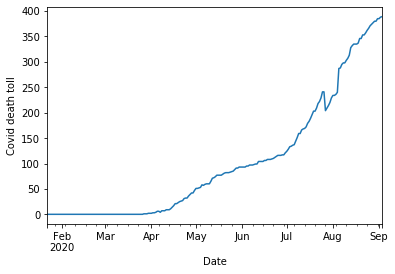

Death toll in Austin - cumulative


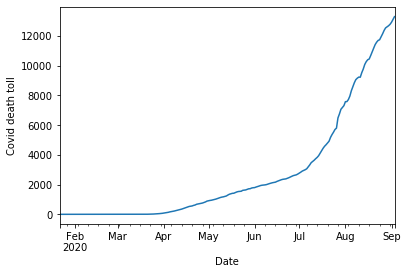

Death toll in Texas - cumulative


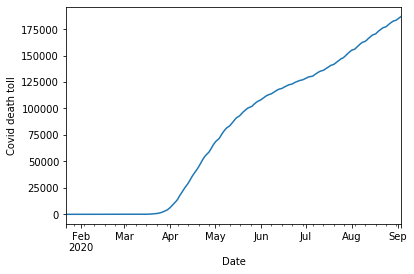

Death toll in US - cumulative


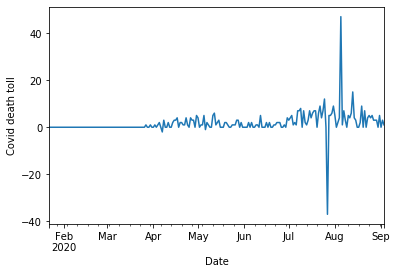

Death toll in Austin - new


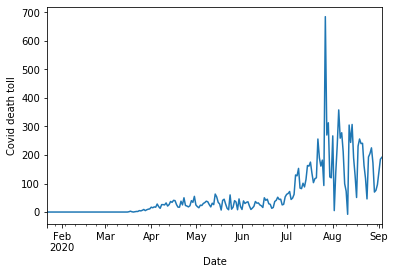

Death toll in Texas - new


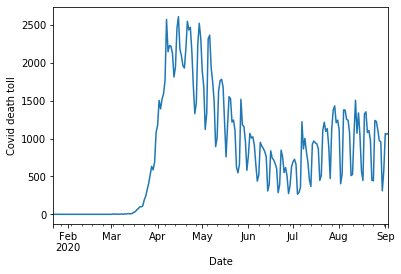

Death toll in US - new 


In [14]:
plotDeathToll(austinDeadSeries, "Austin - cumulative")
plotDeathToll(texasDeadSeries, "Texas - cumulative")
plotDeathToll(usDeadSeries, "US - cumulative")
plotDeathToll(austinNewDeadSeries, "Austin - new")
plotDeathToll(texasNewDeadSeries, "Texas - new")
plotDeathToll(usNewDeadSeries, "US - new ")

We now check to see if there is a seasonal component on either cumulative or new deaths in any of the three regions of interest

C:\Users\aparna\anaconda3\lib\site-packages\ipykernel_launcher.py:21: FutureWarning: the 'freq'' keyword is deprecated, use 'period' instead
C:\Users\aparna\anaconda3\lib\site-packages\ipykernel_launcher.py:25: FutureWarning: the 'freq'' keyword is deprecated, use 'period' instead
C:\Users\aparna\anaconda3\lib\site-packages\ipykernel_launcher.py:21: FutureWarning: the 'freq'' keyword is deprecated, use 'period' instead
C:\Users\aparna\anaconda3\lib\site-packages\ipykernel_launcher.py:25: FutureWarning: the 'freq'' keyword is deprecated, use 'period' instead
C:\Users\aparna\anaconda3\lib\site-packages\ipykernel_launcher.py:21: FutureWarning: the 'freq'' keyword is deprecated, use 'period' instead
C:\Users\aparna\anaconda3\lib\site-packages\ipykernel_launcher.py:25: FutureWarning: the 'freq'' keyword is deprecated, use 'period' instead


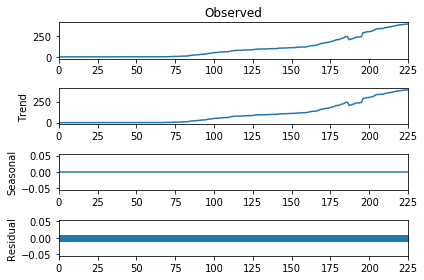

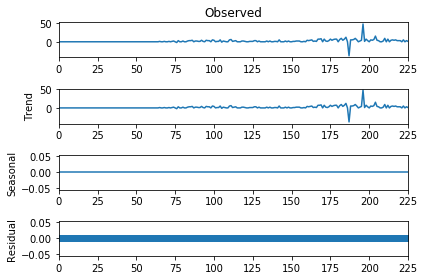

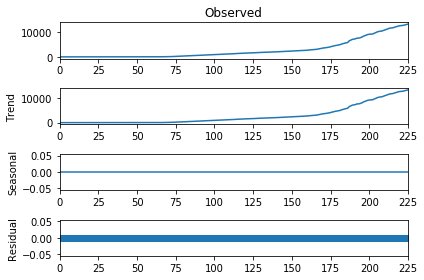

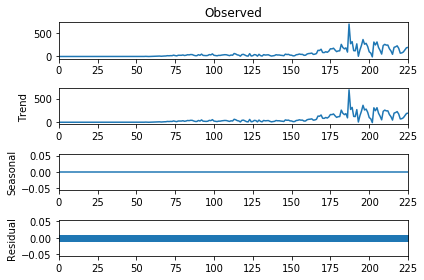

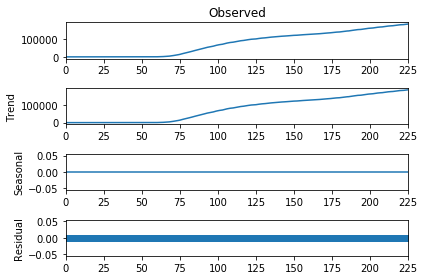

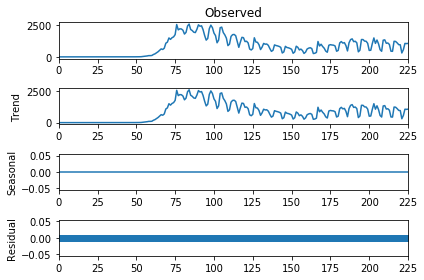

In [15]:
plotSeasonalDecompositionFromDataframe(austin_dead)
plotSeasonalDecompositionFromDataSeries(austinNewDeadSeries)

plotSeasonalDecompositionFromDataframe(texas_dead)
plotSeasonalDecompositionFromDataSeries(texasNewDeadSeries)

plotSeasonalDecompositionFromDataframe(us_cntry_dead)
plotSeasonalDecompositionFromDataSeries(usNewDeadSeries)

We note that
1. There is no seasonal component in either cumulative/new deaths in any of three regions
2. There is a positive trend component in the cumulative deaths in all three regions
3. There is no such trend in the new deaths in all three regions

Lets check to see if the data is stationary
Then we will try to do a forecast with a simple exponential smoothing

There are a number of unit root tests and the Augmented Dickey-Fuller may be one of the more widely used. It uses an autoregressive model and optimizes an information criterion across multiple different lag values.

The null hypothesis of the test is that the time series can be represented by a unit root, that it is not stationary (has some time-dependent structure). The alternate hypothesis (rejecting the null hypothesis) is that the time series is stationary.

We interpret this result using the p-value from the test.
p-value > 0.05: Fail to reject the null hypothesis (H0), the data has a unit root and is non-stationary.
p-value <= 0.05: Reject the null hypothesis (H0), the data does not have a unit root and is stationary.

In [16]:
def checkAugmentedDickeyFuller(data):
    result = adfuller(data)
    print('ADF Statistic: %f' % result[0])
    print('p-value: %f' % result[1])
    print('Critical Values:')
    for key, value in result[4].items():
        print('\t%s: %.3f' % (key, value))

In [17]:
def checkStationary(data):
    adftest = ADFTest(alpha=0.05)
    print(adftest.is_stationary(data))

In [18]:
checkAugmentedDickeyFuller(austin_dead['value'].values)
checkAugmentedDickeyFuller(austinNewDeadSeries.to_numpy().astype(int))
checkAugmentedDickeyFuller(texas_dead['value'].values)
checkAugmentedDickeyFuller(texasNewDeadSeries.to_numpy().astype(int))
checkAugmentedDickeyFuller(us_cntry_dead['value'].values)
checkAugmentedDickeyFuller(usNewDeadSeries.to_numpy().astype(int))

ADF Statistic: 3.495653
p-value: 1.000000
Critical Values:
	1%: -3.461
	5%: -2.875
	10%: -2.574
ADF Statistic: -2.194747
p-value: 0.208157
Critical Values:
	1%: -3.462
	5%: -2.875
	10%: -2.574
ADF Statistic: -0.755086
p-value: 0.831961
Critical Values:
	1%: -3.461
	5%: -2.875
	10%: -2.574
ADF Statistic: -0.704778
p-value: 0.845508
Critical Values:
	1%: -3.461
	5%: -2.875
	10%: -2.574
ADF Statistic: -0.211774
p-value: 0.937104
Critical Values:
	1%: -3.462
	5%: -2.875
	10%: -2.574
ADF Statistic: -2.681857
p-value: 0.077231
Critical Values:
	1%: -3.462
	5%: -2.875
	10%: -2.574


In all of the cases, p value is > 0.05. So we cannot reject the notion that the series are time-dependant and non-stationary. However, since we know there is a trend component in all cases, lets also apply the kpss test.
Also note, that we check stationarity to determine if we should use the ARMA model (if stationary) or the ARIMA model (if not) as ARIMA is computationally more complex.

In [19]:
checkStationary(austin_dead['value'])
checkStationary(austinNewDeadSeries.to_numpy().astype(int))
checkStationary(texas_dead['value'])
checkStationary(texasNewDeadSeries.to_numpy().astype(int))
checkStationary(us_cntry_dead['value'])
checkStationary(usNewDeadSeries.to_numpy().astype(int))

(0.99, True)
(0.01, False)
(0.99, True)
(0.3453120212400286, True)
(0.01, False)
(0.9577556740652284, True)


C:\Users\aparna\anaconda3\lib\site-packages\ipykernel_launcher.py:3: DeprecationWarning: is_stationary is deprecated and will be removed in a future release of pmdarima. Use should_diff instead.
  This is separate from the ipykernel package so we can avoid doing imports until
C:\Users\aparna\anaconda3\lib\site-packages\ipykernel_launcher.py:3: DeprecationWarning: is_stationary is deprecated and will be removed in a future release of pmdarima. Use should_diff instead.
  This is separate from the ipykernel package so we can avoid doing imports until
C:\Users\aparna\anaconda3\lib\site-packages\ipykernel_launcher.py:3: DeprecationWarning: is_stationary is deprecated and will be removed in a future release of pmdarima. Use should_diff instead.
  This is separate from the ipykernel package so we can avoid doing imports until
C:\Users\aparna\anaconda3\lib\site-packages\ipykernel_launcher.py:3: DeprecationWarning: is_stationary is deprecated and will be removed in a future release of pmdarima.

In [20]:
def kpss_test(series, **kw):    
    statistic, p_value, n_lags, critical_values = kpss(series, **kw)
    # Format Output
    print(f'KPSS Statistic: {statistic}')
    print(f'p-value: {p_value}')
    print(f'num lags: {n_lags}')
    print('Critial Values:')
    for key, value in critical_values.items():
        print(f'   {key} : {value}')
    print(f'Result: The series is {"not " if p_value < 0.05 else ""}stationary')

In [21]:
kpss_test(austin_dead['value'])
kpss_test(austinNewDeadSeries.to_numpy().astype(int))
kpss_test(texas_dead['value'])
kpss_test(texasNewDeadSeries.to_numpy().astype(int))
kpss_test(us_cntry_dead['value'])
kpss_test(usNewDeadSeries.to_numpy().astype(int))

KPSS Statistic: 1.3194309978839975
p-value: 0.01
num lags: 15
Critial Values:
   10% : 0.347
   5% : 0.463
   2.5% : 0.574
   1% : 0.739
Result: The series is not stationary
KPSS Statistic: 0.9820598409506772
p-value: 0.01
num lags: 15
Critial Values:
   10% : 0.347
   5% : 0.463
   2.5% : 0.574
   1% : 0.739
Result: The series is not stationary
KPSS Statistic: 1.1793774246077646
p-value: 0.01
num lags: 15
Critial Values:
   10% : 0.347
   5% : 0.463
   2.5% : 0.574
   1% : 0.739
Result: The series is not stationary
KPSS Statistic: 1.1064928491270014
p-value: 0.01
num lags: 15
Critial Values:
   10% : 0.347
   5% : 0.463
   2.5% : 0.574
   1% : 0.739
Result: The series is not stationary
KPSS Statistic: 1.4808584112120702
p-value: 0.01
num lags: 15
Critial Values:
   10% : 0.347
   5% : 0.463
   2.5% : 0.574
   1% : 0.739
Result: The series is not stationary
KPSS Statistic: 0.3626545118504727
p-value: 0.0932523655816928
num lags: 15
Critial Values:
   10% : 0.347
   5% : 0.463
   2.5% :

C:\Users\aparna\anaconda3\lib\site-packages\statsmodels\tsa\stattools.py:1661: FutureWarning: The behavior of using lags=None will change in the next release. Currently lags=None is the same as lags='legacy', and so a sample-size lag length is used. After the next release, the default will change to be the same as lags='auto' which uses an automatic lag length selection method. To silence this warning, either use 'auto' or 'legacy'
  warn(msg, FutureWarning)
C:\Users\aparna\anaconda3\lib\site-packages\statsmodels\tsa\stattools.py:1685: InterpolationWarning: p-value is smaller than the indicated p-value
  warn("p-value is smaller than the indicated p-value", InterpolationWarning)
C:\Users\aparna\anaconda3\lib\site-packages\statsmodels\tsa\stattools.py:1685: InterpolationWarning: p-value is smaller than the indicated p-value
  warn("p-value is smaller than the indicated p-value", InterpolationWarning)
C:\Users\aparna\anaconda3\lib\site-packages\statsmodels\tsa\stattools.py:1685: Interpol

Here we forecast first using Exponential smoothing

C:\Users\aparna\anaconda3\lib\site-packages\statsmodels\tsa\holtwinters.py:731: RuntimeWarning: invalid value encountered in greater_equal
  loc = initial_p >= ub


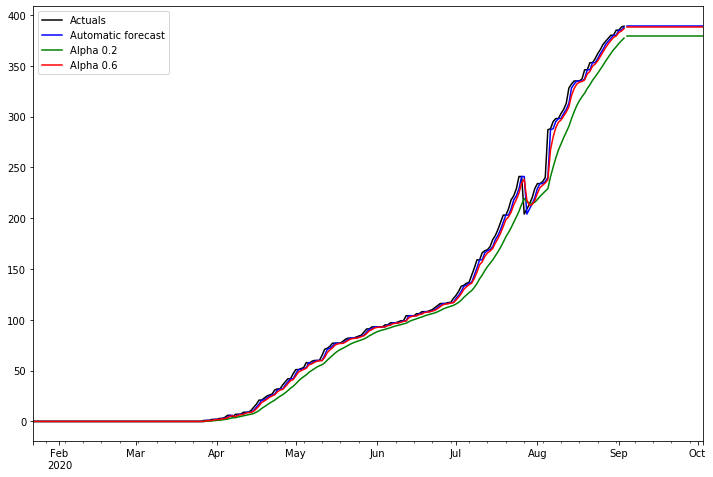

Death toll in Austin - cumulative


C:\Users\aparna\anaconda3\lib\site-packages\statsmodels\tsa\holtwinters.py:731: RuntimeWarning: invalid value encountered in greater_equal
  loc = initial_p >= ub


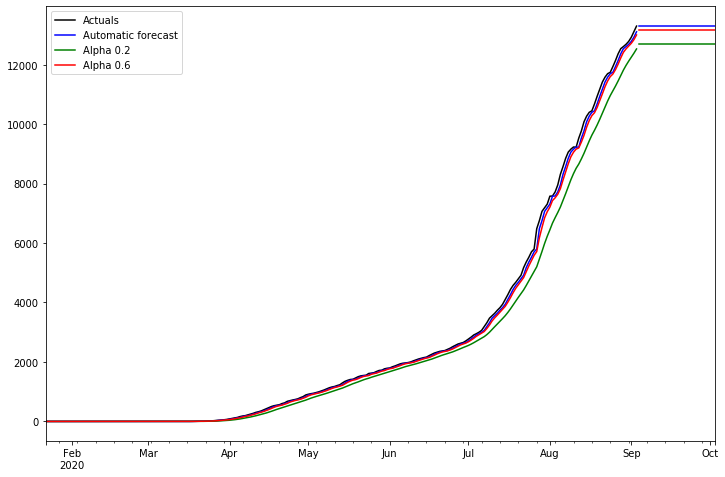

Death toll in Texas - cumulative


C:\Users\aparna\anaconda3\lib\site-packages\statsmodels\tsa\holtwinters.py:731: RuntimeWarning: invalid value encountered in greater_equal
  loc = initial_p >= ub


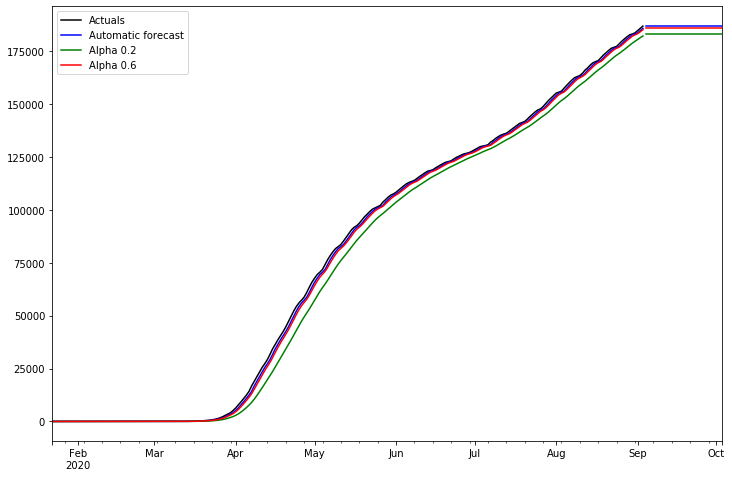

Death toll in US - cumulative


In [22]:
def plotSimpleExponentialSmoothing(deadSeries, regionName, showFit1 = False,  showFit2 = False, showFit3 = False):
    ax = deadSeries.plot( color="black", figsize=(12,8), label= "Actuals")
    if showFit1:
        fit1Series = SimpleExpSmoothing(deadSeries).fit()
        fcast1Series = fit1Series.forecast(30)
        fcast1Series.plot( ax= ax, color="blue", label="Authomatic fit")
        fit1Series.fittedvalues.plot( ax= ax, color="blue")
    if showFit2:
        fit2Series = SimpleExpSmoothing(deadSeries).fit(smoothing_level=0.2,optimized=False)
        fcast2Series = fit2Series.forecast(30)
        fcast2Series.plot( ax= ax, color="green", label="0.2")
        fit2Series.fittedvalues.plot(ax= ax, color="green")    
    if showFit3:
        fit3Series = SimpleExpSmoothing(deadSeries).fit(smoothing_level=0.6,optimized=False)
        fcast3Series = fit3Series.forecast(30)
        fcast3Series.plot( ax= ax, color="red", label="0.6")
        fit3Series.fittedvalues.plot(ax= ax, color="red")
    if showFit1 == True and showFit2 == True and showFit3==True:
        ax.legend(['Actuals','Automatic forecast','Alpha 0.2','Alpha 0.6'])
        ax.get_legend().legendHandles[0].set_color('black')
        ax.get_legend().legendHandles[1].set_color('blue')
        ax.get_legend().legendHandles[2].set_color('green')
        ax.get_legend().legendHandles[3].set_color('red')
    elif showFit1 == True and showFit2 == True and showFit3==False:
        ax.legend(['Actuals','Automatic forecast','Alpha 0.2'])
        ax.get_legend().legendHandles[0].set_color('black')
        ax.get_legend().legendHandles[1].set_color('blue')
        ax.get_legend().legendHandles[2].set_color('green')
    elif showFit1 == True and showFit2 == False and showFit3==True:
        ax.legend(['Actuals','Automatic forecast','Alpha 0.6'])
        ax.get_legend().legendHandles[0].set_color('black')
        ax.get_legend().legendHandles[1].set_color('blue')
        ax.get_legend().legendHandles[2].set_color('red')
    elif showFit1 == True and showFit2 == False and showFit3==False:
        ax.legend(['Actuals','Automatic forecast'])
        ax.get_legend().legendHandles[0].set_color('black')
        ax.get_legend().legendHandles[1].set_color('blue')
    elif showFit1 == False and showFit2 == True and showFit3==True:
        ax.legend(['Actuals','Alpha 0.2','Alpha 0.6'])
        ax.get_legend().legendHandles[0].set_color('black')
        ax.get_legend().legendHandles[1].set_color('green')
        ax.get_legend().legendHandles[2].set_color('red')
    elif showFit1 == False and showFit2 == True and showFit3==False:
        ax.legend(['Actuals','Alpha 0.2'])
        ax.get_legend().legendHandles[0].set_color('black')
        ax.get_legend().legendHandles[1].set_color('green')
    elif showFit1 == False and showFit2 == False and showFit3==True:
        ax.legend(['Actuals','Alpha 0.6'])
        ax.get_legend().legendHandles[0].set_color('black')
        ax.get_legend().legendHandles[2].set_color('red')
    elif showFit1 == False and showFit2 == False and showFit3==False:
        ax.legend(['Actuals'])
        ax.get_legend().legendHandles[0].set_color('black')
       
    plt.show()
    print("Death toll in", regionName)
    
plotSimpleExponentialSmoothing(austinDeadSeries, "Austin - cumulative", True, True, True)
plotSimpleExponentialSmoothing(texasDeadSeries, "Texas - cumulative", True, True, True)
plotSimpleExponentialSmoothing(usDeadSeries, "US - cumulative", True, True, True)



The best prediction is from the automatically fit model. However the forecast is not useful. Lets now look at how simple exponential forecasting works for the new dead in all three regions

C:\Users\aparna\anaconda3\lib\site-packages\statsmodels\tsa\holtwinters.py:731: RuntimeWarning: invalid value encountered in greater_equal
  loc = initial_p >= ub


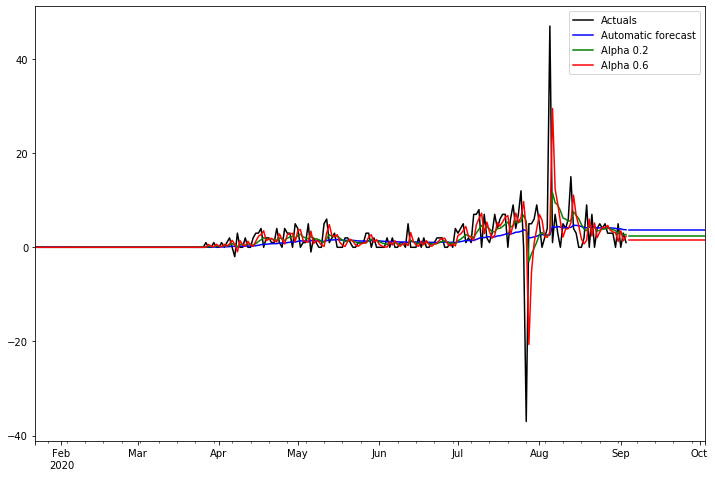

Death toll in Austin - new


C:\Users\aparna\anaconda3\lib\site-packages\statsmodels\tsa\holtwinters.py:731: RuntimeWarning: invalid value encountered in greater_equal
  loc = initial_p >= ub


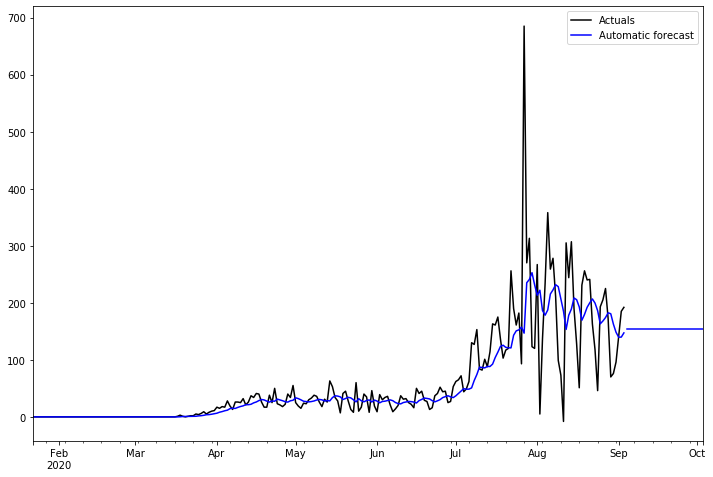

Death toll in Texas - new


C:\Users\aparna\anaconda3\lib\site-packages\statsmodels\tsa\holtwinters.py:731: RuntimeWarning: invalid value encountered in greater_equal
  loc = initial_p >= ub


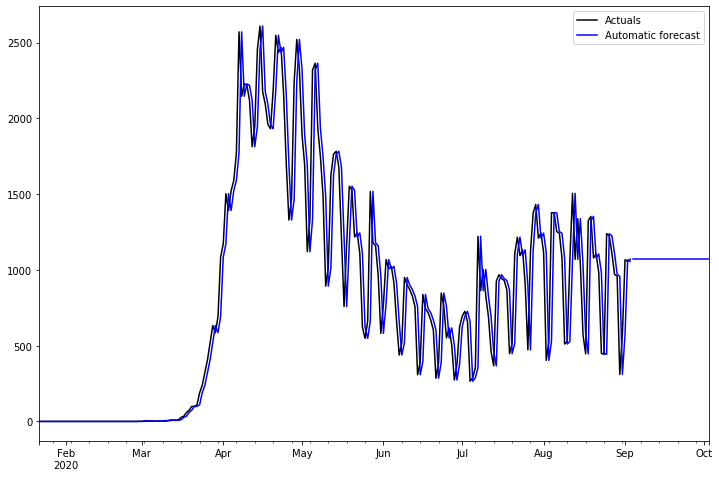

Death toll in US - new


In [23]:
plotSimpleExponentialSmoothing(austinNewDeadSeries, "Austin - new", True, True, True)
plotSimpleExponentialSmoothing(texasNewDeadSeries, "Texas - new", True, False, False)
plotSimpleExponentialSmoothing(usNewDeadSeries, "US - new", True, False, False)

Now it appears for Austin and Texas, the alpha = 0.6 provides a better fit for onserved values and the automatic fit for US new deaths. However, it looks like we can still do better for the forecast. Lets try Holts Linear and damped methods.

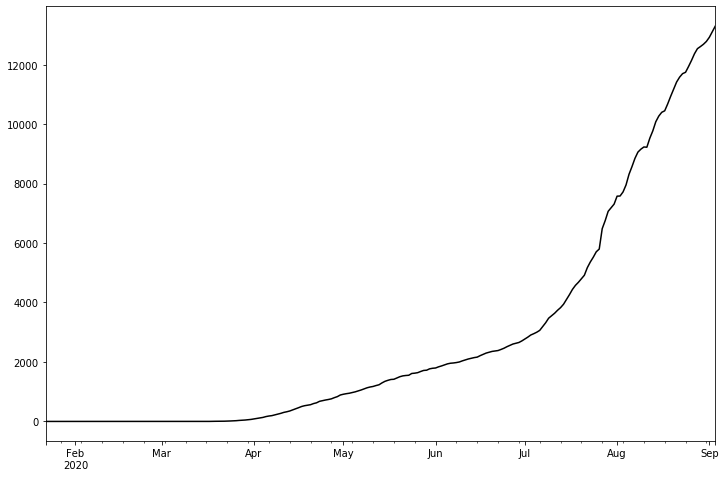

Cumulative Death toll in  Texas


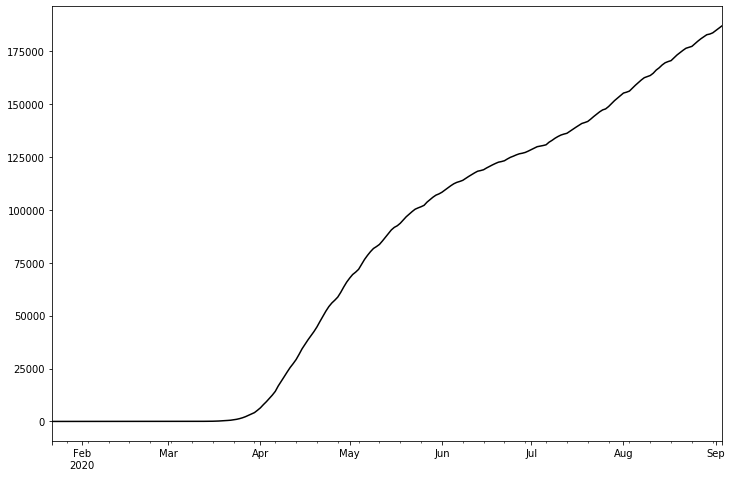

Cumulative Death toll in  US


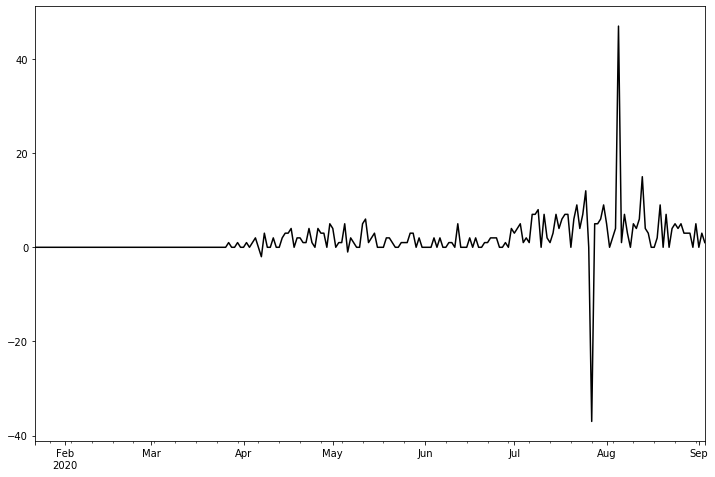

Cumulative Death toll in  Austin - new 


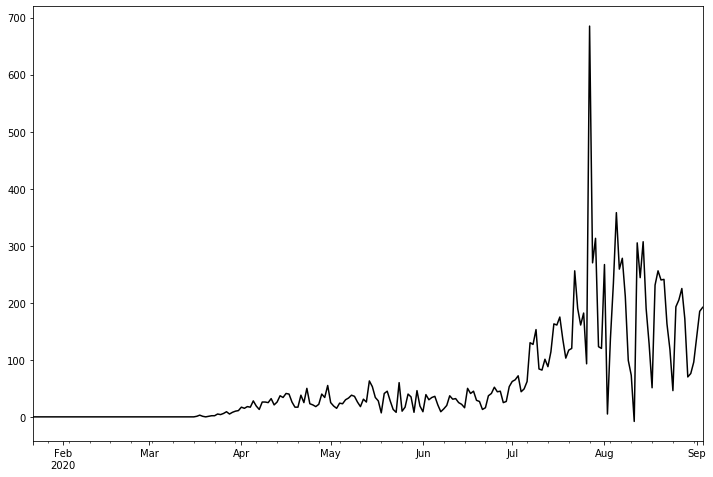

Cumulative Death toll in  Texas - new


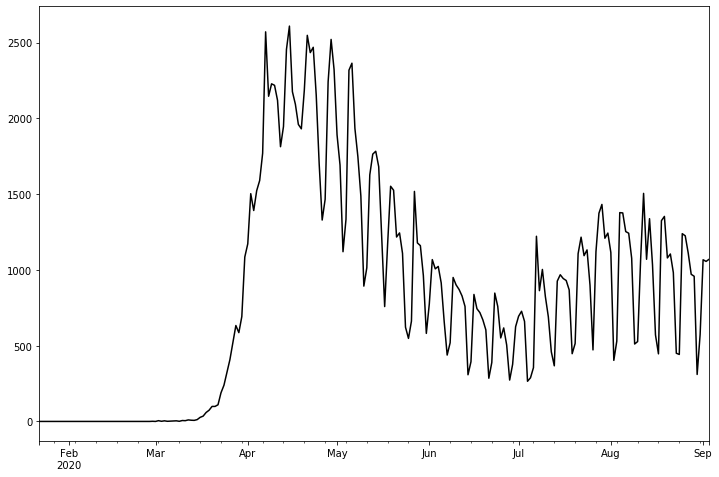

Cumulative Death toll in  US - new


In [24]:
def plotHoltLinearModel(deadSeries, regionName, showHolt = False, showDamped = False):
    if showHolt == True:
        fit1 = Holt(deadSeries).fit()
        fcast1 = fit1.forecast(30)
    if showDamped == True:
        fit2 = Holt(deadSeries, damped=True).fit(smoothing_level=0.8, smoothing_slope=0.2)
        fcast2 = fit2.forecast(30)
    ax = deadSeries.plot(color="black",  figsize=(12,8))
    if showHolt == True:
        fit1.fittedvalues.plot(ax=ax, color='red')
        fcast1.plot(ax=ax, color='red')
    if showDamped == True:
        fit2.fittedvalues.plot(ax=ax, color='green')
        fcast2.plot(ax=ax, color='green')
    if showDamped == True and showHolt == True:
        ax.legend(["Actuals", "Holt's linear trend", "Additive damped trend"])
        ax.get_legend().legendHandles[0].set_color('black')
        ax.get_legend().legendHandles[1].set_color('red')
        ax.get_legend().legendHandles[2].set_color('green')
    elif showDamped == True and showHolt == False:
        ax.legend(["Actuals", "Holts Additive damped trend"])
        ax.get_legend().legendHandles[0].set_color('black')
        ax.get_legend().legendHandles[1].set_color('green')
    elif showDamped == False and showHolt == True:
        ax.legend(["Actuals", "Holt's linear trend"])
        ax.get_legend().legendHandles[0].set_color('black')
        ax.get_legend().legendHandles[1].set_color('red')
       
    plt.show()
    print("Cumulative Death toll in ", regionName)
    

plotHoltLinearModel(texasDeadSeries, "Texas")
plotHoltLinearModel(usDeadSeries, "US")

plotHoltLinearModel(austinNewDeadSeries, "Austin - new ")
plotHoltLinearModel(texasNewDeadSeries, "Texas - new")
plotHoltLinearModel(usNewDeadSeries, "US - new")

C:\Users\aparna\anaconda3\lib\site-packages\statsmodels\tsa\holtwinters.py:731: RuntimeWarning: invalid value encountered in greater_equal
  loc = initial_p >= ub


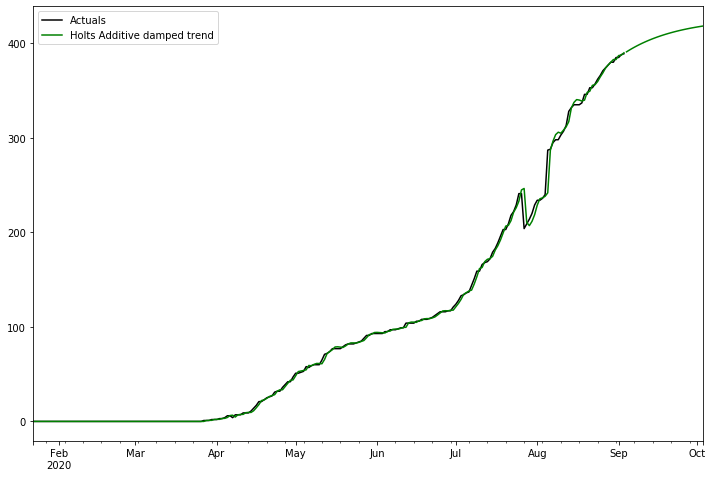

Cumulative Death toll in  Austin


In [25]:
plotHoltLinearModel(austinDeadSeries, "Austin", showHolt=False, showDamped =True)

We see that from a fit perspective, for the most part, Holts trend and Holts damped trend performs similarly except that fpr Austin and Texas new deaths per day, the Holts damped method provides a better fit. It looks like we can do better with the forecast still. Lets try ARIMA next.

In [26]:
def plotARIMAFitAndForecast(deadSeries, isCumulative = False):
    data = deadSeries.to_numpy().astype(int)
    #model = auto_arima(data, trace=True, error_action='ignore', suppress_warnings=True)
    #model = auto_arima(data, start_p = 1, start_q=1, max_p = 14, max_q=14,seasonal=False, d=1, error_action='warn', suppress_warnings='True')
    #model = auto_arima(data, max_order=None,trace=True, start_p = 10, start_q=10, max_p = 14, max_q=14,seasonal=False, d=1, error_action='warn', suppress_warnings='True')
    if isCumulative == True:
        model = auto_arima(data, max_order=None,trace=True, start_p = 13, start_q=13, max_p = 14, max_q=14,seasonal=False, d=1, error_action='warn', suppress_warnings='True')
    else:
        model = auto_arima(data, max_order=None,trace=True, start_p = 7, start_q=7, max_p = 14, max_q=14,seasonal=False, d=1, error_action='warn', suppress_warnings='True')

        
    model.fit(data)
    startDate = deadSeries.first("D").index[0].date()
    endDate = deadSeries.last("D").index[0].date()
    forecastStartDate = (deadSeries.last("D").index[0] + datetime.timedelta(days=1)).date()
    forecastEndDate = (deadSeries.last("D").index[0] + datetime.timedelta(days=30)).date()
    forecast = model.predict(30).astype(int)
    dataFrame = pd.DataFrame(data,index = pd.date_range(start=startDate,end=endDate,freq="D"))
    forecastFrame = pd.DataFrame(forecast,index = pd.date_range(start=forecastStartDate,end=forecastEndDate,freq="D"))
    #plot the predictions for validation set
    plt.plot(dataFrame, label='Train')
    plt.plot(forecastFrame, label='Prediction')
    plt.show()
    

Performing stepwise search to minimize aic
Fit ARIMA(13,1,13)x(0,0,0,0) [intercept=True]; AIC=1283.472, BIC=1379.123, Time=3.673 seconds
Fit ARIMA(0,1,0)x(0,0,0,0) [intercept=True]; AIC=1338.845, BIC=1345.677, Time=0.023 seconds
Fit ARIMA(1,1,0)x(0,0,0,0) [intercept=True]; AIC=1337.637, BIC=1347.885, Time=0.079 seconds
Fit ARIMA(0,1,1)x(0,0,0,0) [intercept=True]; AIC=1337.884, BIC=1348.133, Time=0.094 seconds
Fit ARIMA(0,1,0)x(0,0,0,0) [intercept=False]; AIC=1365.408, BIC=1368.825, Time=0.018 seconds
Fit ARIMA(12,1,13)x(0,0,0,0) [intercept=True]; AIC=1282.527, BIC=1374.762, Time=3.070 seconds
Near non-invertible roots for order (12, 1, 13)(0, 0, 0, 0); setting score to inf (at least one inverse root too close to the border of the unit circle: 1.000)
Fit ARIMA(13,1,12)x(0,0,0,0) [intercept=True]; AIC=1280.429, BIC=1372.664, Time=2.997 seconds
Near non-invertible roots for order (13, 1, 12)(0, 0, 0, 0); setting score to inf (at least one inverse root too close to the border of the unit c

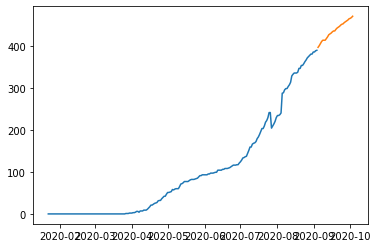

Performing stepwise search to minimize aic
Fit ARIMA(7,1,7)x(0,0,0,0) [intercept=True]; AIC=1286.705, BIC=1341.363, Time=1.563 seconds
Fit ARIMA(0,1,0)x(0,0,0,0) [intercept=True]; AIC=1466.156, BIC=1472.988, Time=0.014 seconds
Fit ARIMA(1,1,0)x(0,0,0,0) [intercept=True]; AIC=1414.437, BIC=1424.686, Time=0.043 seconds
Fit ARIMA(0,1,1)x(0,0,0,0) [intercept=True]; AIC=1324.092, BIC=1334.341, Time=0.263 seconds
Near non-invertible roots for order (0, 1, 1)(0, 0, 0, 0); setting score to inf (at least one inverse root too close to the border of the unit circle: 1.000)
Fit ARIMA(0,1,0)x(0,0,0,0) [intercept=False]; AIC=1464.156, BIC=1467.572, Time=0.012 seconds
Fit ARIMA(6,1,7)x(0,0,0,0) [intercept=True]; AIC=1310.454, BIC=1361.695, Time=1.495 seconds
Near non-invertible roots for order (6, 1, 7)(0, 0, 0, 0); setting score to inf (at least one inverse root too close to the border of the unit circle: 0.999)
Fit ARIMA(7,1,6)x(0,0,0,0) [intercept=True]; AIC=1293.618, BIC=1344.860, Time=1.189 seco

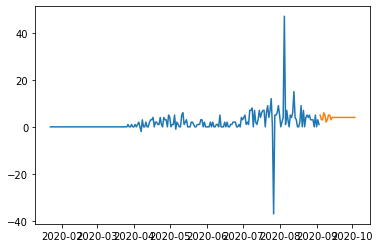

In [27]:
plotARIMAFitAndForecast(austinDeadSeries, isCumulative = True)
plotARIMAFitAndForecast(austinNewDeadSeries)

Performing stepwise search to minimize aic
Fit ARIMA(13,1,13)x(0,0,0,0) [intercept=True]; AIC=2415.477, BIC=2511.128, Time=3.495 seconds
Fit ARIMA(0,1,0)x(0,0,0,0) [intercept=True]; AIC=2656.238, BIC=2663.070, Time=0.015 seconds
Fit ARIMA(1,1,0)x(0,0,0,0) [intercept=True]; AIC=2504.229, BIC=2514.477, Time=0.118 seconds
Fit ARIMA(0,1,1)x(0,0,0,0) [intercept=True]; AIC=2580.796, BIC=2591.044, Time=0.169 seconds
Fit ARIMA(0,1,0)x(0,0,0,0) [intercept=False]; AIC=2738.323, BIC=2741.739, Time=0.010 seconds
Fit ARIMA(12,1,13)x(0,0,0,0) [intercept=True]; AIC=2416.666, BIC=2508.900, Time=3.560 seconds
Near non-invertible roots for order (12, 1, 13)(0, 0, 0, 0); setting score to inf (at least one inverse root too close to the border of the unit circle: 0.999)
Fit ARIMA(13,1,12)x(0,0,0,0) [intercept=True]; AIC=2414.279, BIC=2506.514, Time=3.310 seconds
Near non-invertible roots for order (13, 1, 12)(0, 0, 0, 0); setting score to inf (at least one inverse root too close to the border of the unit c

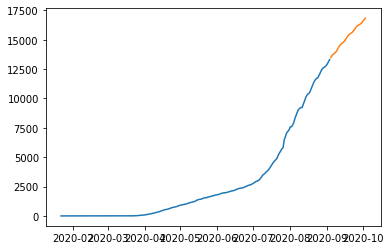

Performing stepwise search to minimize aic
Fit ARIMA(7,1,7)x(0,0,0,0) [intercept=True]; AIC=2396.379, BIC=2451.036, Time=1.604 seconds
Fit ARIMA(0,1,0)x(0,0,0,0) [intercept=True]; AIC=2536.032, BIC=2542.864, Time=0.016 seconds
Fit ARIMA(1,1,0)x(0,0,0,0) [intercept=True]; AIC=2491.185, BIC=2501.433, Time=0.061 seconds
Fit ARIMA(0,1,1)x(0,0,0,0) [intercept=True]; AIC=2454.694, BIC=2464.942, Time=0.065 seconds
Fit ARIMA(0,1,0)x(0,0,0,0) [intercept=False]; AIC=2534.068, BIC=2537.484, Time=0.011 seconds
Fit ARIMA(6,1,7)x(0,0,0,0) [intercept=True]; AIC=2403.607, BIC=2454.849, Time=1.379 seconds
Fit ARIMA(7,1,6)x(0,0,0,0) [intercept=True]; AIC=2399.924, BIC=2451.166, Time=1.210 seconds
Near non-invertible roots for order (7, 1, 6)(0, 0, 0, 0); setting score to inf (at least one inverse root too close to the border of the unit circle: 0.998)
Fit ARIMA(8,1,7)x(0,0,0,0) [intercept=True]; AIC=2402.612, BIC=2460.685, Time=1.530 seconds
Near non-invertible roots for order (8, 1, 7)(0, 0, 0, 0); set

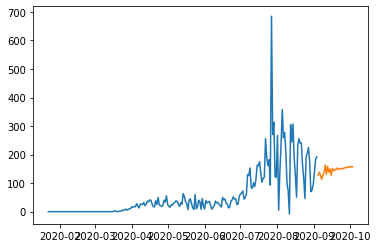

In [28]:
plotARIMAFitAndForecast(texasDeadSeries, isCumulative = True)
plotARIMAFitAndForecast(texasNewDeadSeries, isCumulative = False)

Performing stepwise search to minimize aic
Fit ARIMA(13,1,13)x(0,0,0,0) [intercept=True]; AIC=2988.941, BIC=3084.592, Time=3.305 seconds
Fit ARIMA(0,1,0)x(0,0,0,0) [intercept=True]; AIC=3598.916, BIC=3605.748, Time=0.016 seconds
Fit ARIMA(1,1,0)x(0,0,0,0) [intercept=True]; AIC=3171.286, BIC=3181.535, Time=0.148 seconds
Fit ARIMA(0,1,1)x(0,0,0,0) [intercept=True]; AIC=3378.758, BIC=3389.006, Time=0.187 seconds
Fit ARIMA(0,1,0)x(0,0,0,0) [intercept=False]; AIC=3789.633, BIC=3793.050, Time=0.008 seconds
Fit ARIMA(12,1,13)x(0,0,0,0) [intercept=True]; AIC=2990.903, BIC=3083.138, Time=3.415 seconds
Near non-invertible roots for order (12, 1, 13)(0, 0, 0, 0); setting score to inf (at least one inverse root too close to the border of the unit circle: 0.999)
Fit ARIMA(13,1,12)x(0,0,0,0) [intercept=True]; AIC=2975.860, BIC=3068.094, Time=2.999 seconds
Fit ARIMA(12,1,12)x(0,0,0,0) [intercept=True]; AIC=2976.652, BIC=3065.470, Time=2.928 seconds
Fit ARIMA(13,1,11)x(0,0,0,0) [intercept=True]; AIC=2

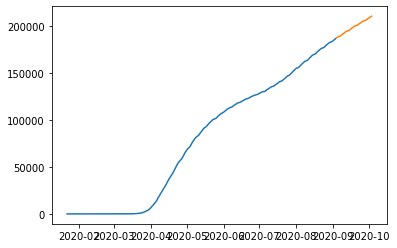

Performing stepwise search to minimize aic
Fit ARIMA(7,1,7)x(0,0,0,0) [intercept=True]; AIC=2967.782, BIC=3022.440, Time=1.461 seconds
Fit ARIMA(0,1,0)x(0,0,0,0) [intercept=True]; AIC=3176.156, BIC=3182.988, Time=0.016 seconds
Fit ARIMA(1,1,0)x(0,0,0,0) [intercept=True]; AIC=3176.358, BIC=3186.607, Time=0.032 seconds
Fit ARIMA(0,1,1)x(0,0,0,0) [intercept=True]; AIC=3173.688, BIC=3183.936, Time=0.104 seconds
Fit ARIMA(0,1,0)x(0,0,0,0) [intercept=False]; AIC=3174.222, BIC=3177.638, Time=0.009 seconds
Fit ARIMA(6,1,7)x(0,0,0,0) [intercept=True]; AIC=2969.162, BIC=3020.403, Time=1.384 seconds
Near non-invertible roots for order (6, 1, 7)(0, 0, 0, 0); setting score to inf (at least one inverse root too close to the border of the unit circle: 0.993)
Fit ARIMA(7,1,6)x(0,0,0,0) [intercept=True]; AIC=2973.553, BIC=3024.795, Time=1.455 seconds
Fit ARIMA(8,1,7)x(0,0,0,0) [intercept=True]; AIC=2970.867, BIC=3028.941, Time=1.713 seconds
Fit ARIMA(7,1,8)x(0,0,0,0) [intercept=True]; AIC=2968.721, BIC

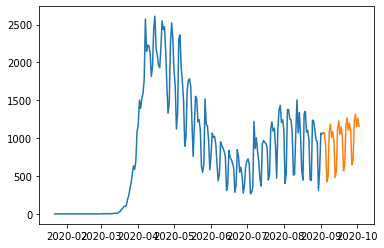

In [29]:
plotARIMAFitAndForecast(usDeadSeries, isCumulative = True)
plotARIMAFitAndForecast(usNewDeadSeries, isCumulative = False)

Given that we have seen predictions from different models, we now want to see if we can quantitatively see which model is more accurate. In the remaining section, we try to see which of the models has the least error if we try a train-test split of 80%

In [30]:
def getTrainTestSplit(dataFrame, pct = 0.75):
    train_pct_index = int(pct *len(dataFrame))
    trainDf = dataFrame.iloc[0: train_pct_index]
    testDf = dataFrame.iloc[train_pct_index:]
    return trainDf, testDf

In [31]:
trainDfAD, testDfAD = getTrainTestSplit(austin_dead, pct = 0.8)

In [32]:
trainDfTD, testDfTD = getTrainTestSplit(texas_dead, pct = 0.8)

In [33]:
trainDfUSD, testDfUSD = getTrainTestSplit(us_cntry_dead, pct = 0.8)

In [34]:
def plotTrainTestFcatSimpleExp(trainDf, testDf):
    fcastLen = len(testDf)
    endTestDate = getEndDate(testDf)
    startTestDate = getStartDate(testDf)
    testSeries = getSeriesFromDataFrame(testDf, startTestDate, endTestDate)
    endTrainDate = getEndDate(trainDf)
    startTrainDate = getStartDate(trainDf)
    trainSeries = getSeriesFromDataFrame(trainDf, startTrainDate, endTrainDate)
   
    ax = trainSeries.plot( color="black", figsize=(12,8), label= "Actuals Train")
    trainFitSeries = SimpleExpSmoothing(trainSeries).fit()
    trainfcastSeries = trainFitSeries.forecast(fcastLen)
    trainfcastSeries.plot( ax= ax, color="blue", label='Train forecast')
    trainFitSeries.fittedvalues.plot( ax= ax, color="blue")
    testSeries.plot(ax=ax, color="green", label="Actuals Test")
    ax.legend(['Actuals Train','Train forecast','Actuals Test'])
    ax.get_legend().legendHandles[0].set_color('black')
    ax.get_legend().legendHandles[1].set_color('blue')
    ax.get_legend().legendHandles[2].set_color('green')
    plt.show()
    
    expected = testSeries.to_numpy().astype(int)
    predictions = trainfcastSeries.to_numpy().astype(int)
    mse = mean_squared_error(expected, predictions)
    rmse = sqrt(mse)
    print('RMSE: %f' % rmse)

C:\Users\aparna\anaconda3\lib\site-packages\statsmodels\tsa\holtwinters.py:731: RuntimeWarning: invalid value encountered in greater_equal
  loc = initial_p >= ub


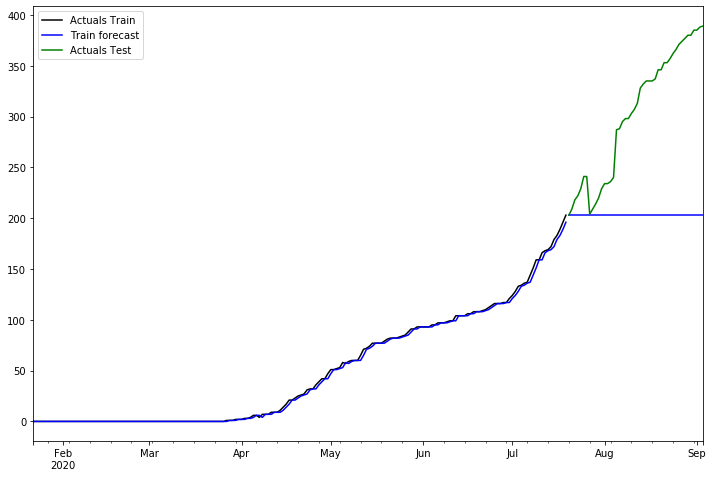

RMSE: 117.290609


In [35]:
plotTrainTestFcatSimpleExp(trainDfAD, testDfAD)

C:\Users\aparna\anaconda3\lib\site-packages\statsmodels\tsa\holtwinters.py:731: RuntimeWarning: invalid value encountered in greater_equal
  loc = initial_p >= ub


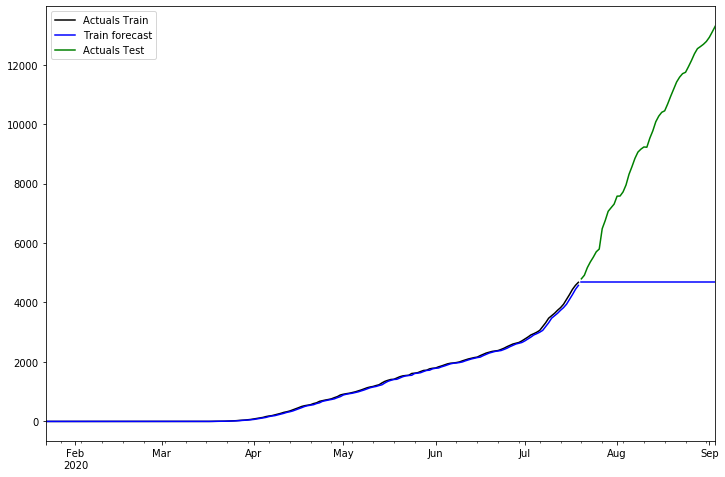

RMSE: 5343.133125


In [36]:
plotTrainTestFcatSimpleExp(trainDfTD, testDfTD)

C:\Users\aparna\anaconda3\lib\site-packages\statsmodels\tsa\holtwinters.py:731: RuntimeWarning: invalid value encountered in greater_equal
  loc = initial_p >= ub


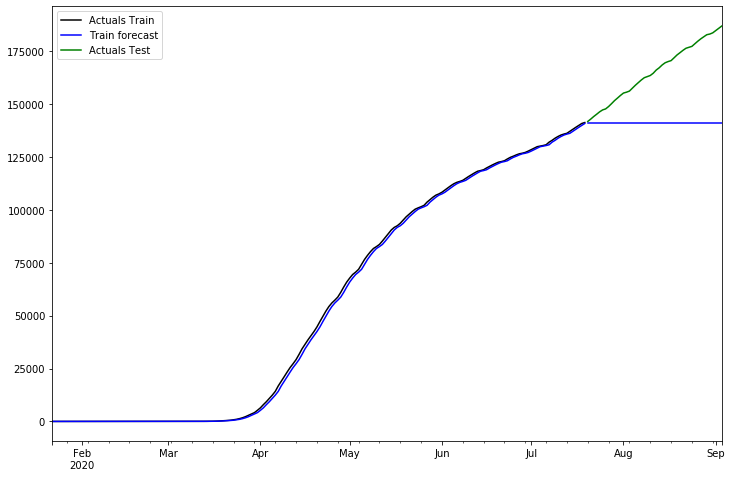

RMSE: 27333.159872


In [37]:
plotTrainTestFcatSimpleExp(trainDfUSD, testDfUSD)

In [38]:
def plotTrainTestFcatHolt(trainDf, testDf):
    fcastLen = len(testDf)
    endTestDate = getEndDate(testDf)
    startTestDate = getStartDate(testDf)
    testSeries = getSeriesFromDataFrame(testDf, startTestDate, endTestDate)
    endTrainDate = getEndDate(trainDf)
    startTrainDate = getStartDate(trainDf)
    trainSeries = getSeriesFromDataFrame(trainDf, startTrainDate, endTrainDate)
   
    ax = trainSeries.plot( color="black", figsize=(12,8), label= "Actuals Train")
    trainFitSeries = Holt(trainSeries).fit()
    trainfcastSeries = trainFitSeries.forecast(fcastLen)
    trainfcastSeries.plot( ax= ax, color="blue", label='Train forecast')
    trainFitSeries.fittedvalues.plot( ax= ax, color="blue")
    testSeries.plot(ax=ax, color="green", label="Actuals Test")
    ax.legend(['Actuals Train','Train forecast','Actuals Test'])
    ax.get_legend().legendHandles[0].set_color('black')
    ax.get_legend().legendHandles[1].set_color('blue')
    ax.get_legend().legendHandles[2].set_color('green')
    plt.show()
    
    expected = testSeries.to_numpy().astype(int)
    predictions = trainfcastSeries.to_numpy().astype(int)
    mse = mean_squared_error(expected, predictions)
    rmse = sqrt(mse)
    print('RMSE: %f' % rmse)

C:\Users\aparna\anaconda3\lib\site-packages\statsmodels\tsa\holtwinters.py:731: RuntimeWarning: invalid value encountered in greater_equal
  loc = initial_p >= ub


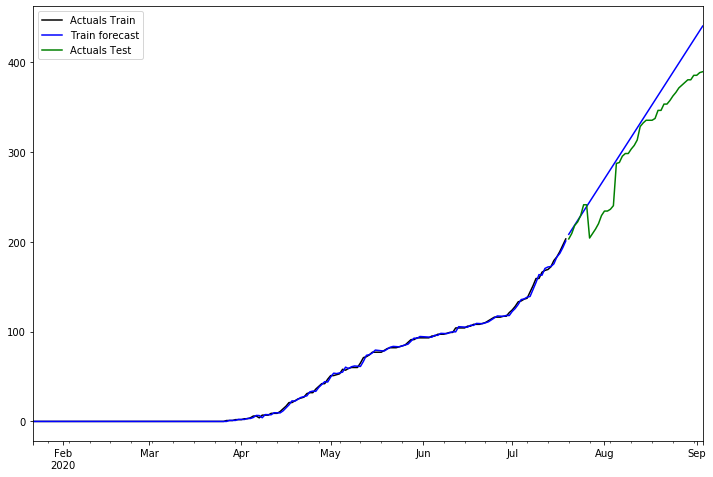

RMSE: 26.885021


In [39]:
plotTrainTestFcatHolt(trainDfAD, testDfAD)

C:\Users\aparna\anaconda3\lib\site-packages\statsmodels\tsa\holtwinters.py:731: RuntimeWarning: invalid value encountered in greater_equal
  loc = initial_p >= ub


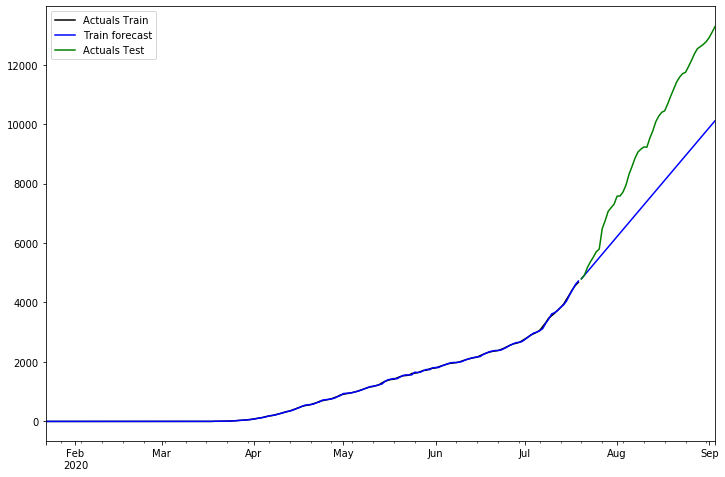

RMSE: 2157.533263


In [40]:
plotTrainTestFcatHolt(trainDfTD, testDfTD)

C:\Users\aparna\anaconda3\lib\site-packages\statsmodels\tsa\holtwinters.py:731: RuntimeWarning: invalid value encountered in greater_equal
  loc = initial_p >= ub
C:\Users\aparna\anaconda3\lib\site-packages\statsmodels\tsa\holtwinters.py:744: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  ConvergenceWarning)


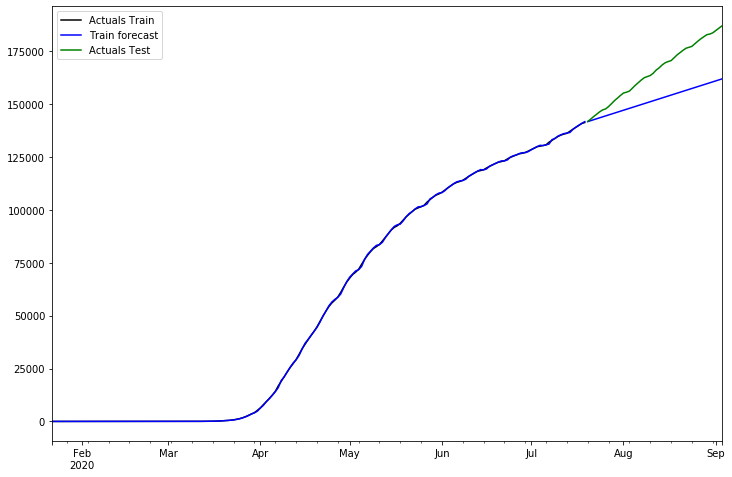

RMSE: 15271.156719


In [41]:
plotTrainTestFcatHolt(trainDfUSD, testDfUSD)

In [42]:
def plotTrainTestFcatHoltDamped(trainDf, testDf):
    fcastLen = len(testDf)
    endTestDate = getEndDate(testDf)
    startTestDate = getStartDate(testDf)
    testSeries = getSeriesFromDataFrame(testDf, startTestDate, endTestDate)
    endTrainDate = getEndDate(trainDf)
    startTrainDate = getStartDate(trainDf)
    trainSeries = getSeriesFromDataFrame(trainDf, startTrainDate, endTrainDate)
   
    ax = trainSeries.plot( color="black", figsize=(12,8), label= "Actuals Train")
    trainFitSeries = Holt(trainSeries, damped=True).fit(smoothing_level=0.8, smoothing_slope=0.2)
    trainfcastSeries = trainFitSeries.forecast(fcastLen)
    trainfcastSeries.plot( ax= ax, color="blue", label='Train forecast')
    trainFitSeries.fittedvalues.plot( ax= ax, color="blue")
    testSeries.plot(ax=ax, color="green", label="Actuals Test")
    ax.legend(['Actuals Train','Train forecast','Actuals Test'])
    ax.get_legend().legendHandles[0].set_color('black')
    ax.get_legend().legendHandles[1].set_color('blue')
    ax.get_legend().legendHandles[2].set_color('green')
    plt.show()
    
    expected = testSeries.to_numpy().astype(int)
    predictions = trainfcastSeries.to_numpy().astype(int)
    mse = mean_squared_error(expected, predictions)
    rmse = sqrt(mse)
    print('RMSE: %f' % rmse)

C:\Users\aparna\anaconda3\lib\site-packages\statsmodels\tsa\holtwinters.py:731: RuntimeWarning: invalid value encountered in greater_equal
  loc = initial_p >= ub


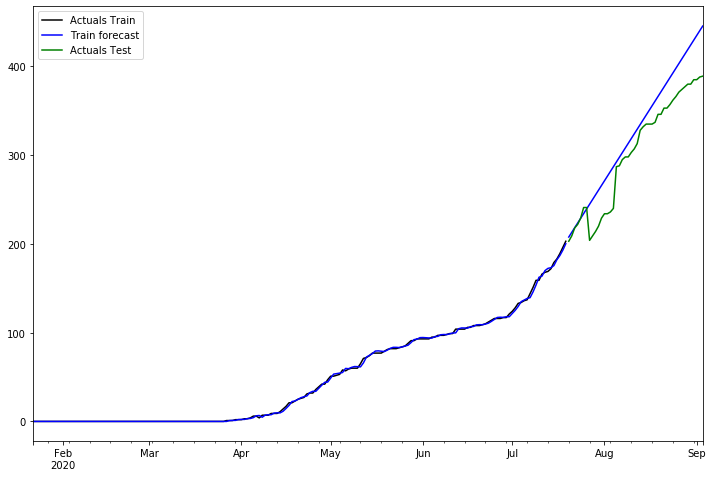

RMSE: 29.473643


In [43]:
plotTrainTestFcatHoltDamped(trainDfAD, testDfAD)

C:\Users\aparna\anaconda3\lib\site-packages\statsmodels\tsa\holtwinters.py:731: RuntimeWarning: invalid value encountered in greater_equal
  loc = initial_p >= ub


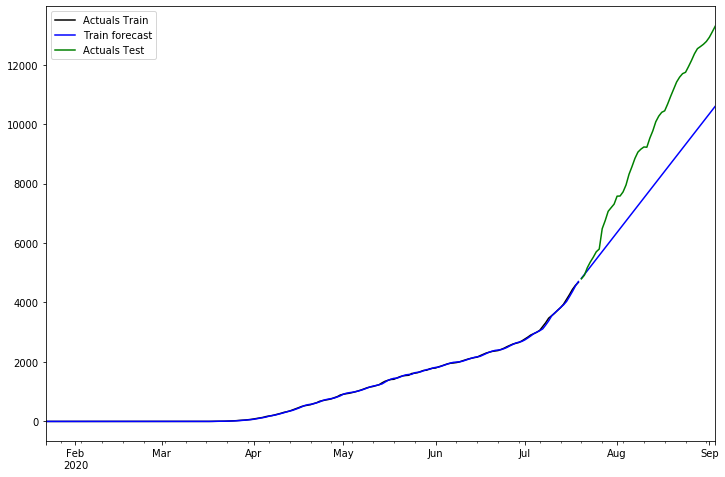

RMSE: 1876.584003


In [44]:
plotTrainTestFcatHoltDamped(trainDfTD, testDfTD)

C:\Users\aparna\anaconda3\lib\site-packages\statsmodels\tsa\holtwinters.py:731: RuntimeWarning: invalid value encountered in greater_equal
  loc = initial_p >= ub


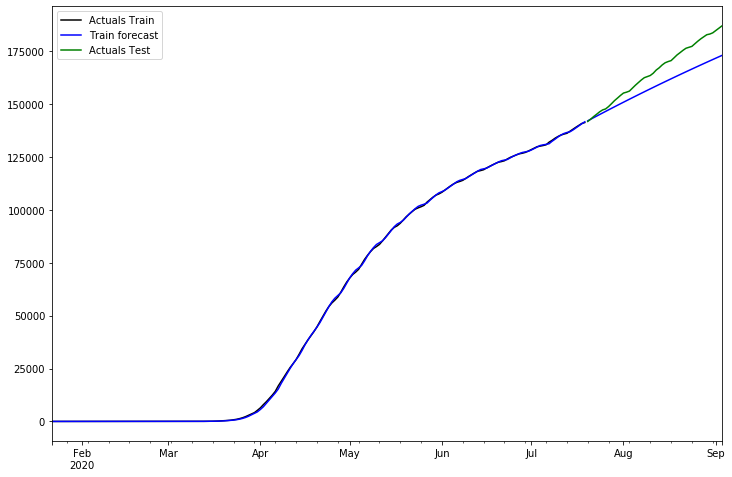

RMSE: 8334.934128


In [45]:
plotTrainTestFcatHoltDamped(trainDfUSD, testDfUSD)

In [46]:
def plotTrainTestFcatArima(trainDf, testDf, isCumulative = False):
    fcastLen = len(testDf)
    endTestDate = getEndDate(testDf)
    startTestDate = getStartDate(testDf)
    testSeries = getSeriesFromDataFrame(testDf, startTestDate, endTestDate)
    endTrainDate = getEndDate(trainDf)
    startTrainDate = getStartDate(trainDf)
    trainSeries = getSeriesFromDataFrame(trainDf, startTrainDate, endTrainDate)
   
    data = trainSeries.to_numpy().astype(int)
    #model = auto_arima(data, trace=True, error_action='ignore', suppress_warnings=True)
    #model = auto_arima(data, start_p = 1, start_q=1, max_p = 14, max_q=14,seasonal=False, d=1, max_d=4, trace=True, error_action='warn', suppress_warnings='True')
    #model = auto_arima(data, start_p = 1, start_q=1, max_p = 14, max_q=14,seasonal=False, d=1, max_d=4, trace=True, error_action='warn', suppress_warnings='True', max_order = 30, stepwise='False', n_jobs=-1)
    # USE start_p = 13 for cumulative
    
    if isCumulative == True:
        model = auto_arima(data, max_order=None,trace=True, start_p = 13, start_q=13, max_p = 14, max_q=14,seasonal=False, d=1, error_action='warn', suppress_warnings='True')
    else:
        model = auto_arima(data, max_order=None,trace=True, start_p = 7, start_q=7, max_p = 14, max_q=14,seasonal=False, d=1, error_action='warn', suppress_warnings='True')

    model.fit(data)
    forecast = model.predict(fcastLen).astype(int)
    trainDataFrame = pd.DataFrame(data,index = pd.date_range(start=startTrainDate,end=endTrainDate,freq="D"))
    forecastFrame = pd.DataFrame(forecast,index = pd.date_range(start=startTestDate,end=endTestDate,freq="D"))
    testDataFrame = pd.DataFrame(testDf["value"].to_numpy().astype(int),index = pd.date_range(start=startTestDate,end=endTestDate,freq="D"))
    plt.xticks(rotation=30)
    plt.plot(trainDataFrame, label='Actual Train', color="black")
    plt.plot(forecastFrame, label='Prediction Test', color="blue")
    plt.plot(testDataFrame ,label="Actual test", color="green")
    plt.show()
    
    expected = testDf["value"].to_numpy().astype(int)
    predictions = forecastFrame.to_numpy().astype(int)
    mse = mean_squared_error(expected, predictions)
    rmse = sqrt(mse)
    print('RMSE: %f' % rmse)

Performing stepwise search to minimize aic
Fit ARIMA(13,1,13)x(0,0,0,0) [intercept=True]; AIC=655.590, BIC=744.837, Time=3.136 seconds
Fit ARIMA(0,1,0)x(0,0,0,0) [intercept=True]; AIC=737.444, BIC=743.819, Time=0.025 seconds
Fit ARIMA(1,1,0)x(0,0,0,0) [intercept=True]; AIC=697.600, BIC=707.163, Time=0.074 seconds
Fit ARIMA(0,1,1)x(0,0,0,0) [intercept=True]; AIC=713.366, BIC=722.928, Time=0.076 seconds
Fit ARIMA(0,1,0)x(0,0,0,0) [intercept=False]; AIC=791.137, BIC=794.324, Time=0.017 seconds
Fit ARIMA(12,1,13)x(0,0,0,0) [intercept=True]; AIC=654.476, BIC=740.535, Time=2.867 seconds
Near non-invertible roots for order (12, 1, 13)(0, 0, 0, 0); setting score to inf (at least one inverse root too close to the border of the unit circle: 0.999)
Fit ARIMA(13,1,12)x(0,0,0,0) [intercept=True]; AIC=657.477, BIC=743.536, Time=2.667 seconds
Near non-invertible roots for order (13, 1, 12)(0, 0, 0, 0); setting score to inf (at least one inverse root too close to the border of the unit circle: 0.998)


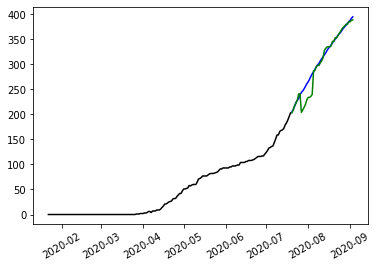

RMSE: 16.659636


In [47]:
plotTrainTestFcatArima(trainDfAD, testDfAD, isCumulative = True)

Performing stepwise search to minimize aic
Fit ARIMA(13,1,13)x(0,0,0,0) [intercept=True]; AIC=1431.807, BIC=1521.054, Time=3.411 seconds
Fit ARIMA(0,1,0)x(0,0,0,0) [intercept=True]; AIC=1771.990, BIC=1778.365, Time=0.012 seconds
Fit ARIMA(1,1,0)x(0,0,0,0) [intercept=True]; AIC=1482.420, BIC=1491.982, Time=0.050 seconds
Fit ARIMA(0,1,1)x(0,0,0,0) [intercept=True]; AIC=1641.386, BIC=1650.948, Time=0.108 seconds
Fit ARIMA(0,1,0)x(0,0,0,0) [intercept=False]; AIC=1854.025, BIC=1857.212, Time=0.013 seconds
Fit ARIMA(12,1,13)x(0,0,0,0) [intercept=True]; AIC=1425.554, BIC=1511.614, Time=2.937 seconds
Near non-invertible roots for order (12, 1, 13)(0, 0, 0, 0); setting score to inf (at least one inverse root too close to the border of the unit circle: 0.999)
Fit ARIMA(13,1,12)x(0,0,0,0) [intercept=True]; AIC=1429.111, BIC=1515.170, Time=2.821 seconds
Near non-invertible roots for order (13, 1, 12)(0, 0, 0, 0); setting score to inf (at least one inverse root too close to the border of the unit c

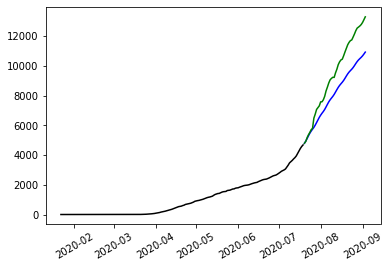

RMSE: 1505.260991


In [48]:
plotTrainTestFcatArima(trainDfTD, testDfTD, isCumulative = True)

Performing stepwise search to minimize aic
Fit ARIMA(13,1,13)x(0,0,0,0) [intercept=True]; AIC=2382.204, BIC=2471.451, Time=3.280 seconds
Fit ARIMA(0,1,0)x(0,0,0,0) [intercept=True]; AIC=2894.380, BIC=2900.755, Time=0.011 seconds
Fit ARIMA(1,1,0)x(0,0,0,0) [intercept=True]; AIC=2486.523, BIC=2496.085, Time=0.109 seconds
Fit ARIMA(0,1,1)x(0,0,0,0) [intercept=True]; AIC=2705.824, BIC=2715.386, Time=0.080 seconds
Fit ARIMA(0,1,0)x(0,0,0,0) [intercept=False]; AIC=3019.335, BIC=3022.522, Time=0.011 seconds
Fit ARIMA(12,1,13)x(0,0,0,0) [intercept=True]; AIC=2380.554, BIC=2466.614, Time=2.881 seconds
Near non-invertible roots for order (12, 1, 13)(0, 0, 0, 0); setting score to inf (at least one inverse root too close to the border of the unit circle: 1.000)
Fit ARIMA(13,1,12)x(0,0,0,0) [intercept=True]; AIC=2377.840, BIC=2463.899, Time=2.615 seconds
Fit ARIMA(12,1,12)x(0,0,0,0) [intercept=True]; AIC=2376.413, BIC=2459.285, Time=2.427 seconds
Fit ARIMA(11,1,12)x(0,0,0,0) [intercept=True]; AIC=2

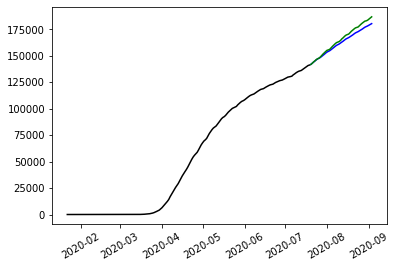

RMSE: 3550.199850


In [49]:
plotTrainTestFcatArima(trainDfUSD, testDfUSD, isCumulative = True)

As of September-2020, the US cumulative dead series is best predicted by the ARIMA model with the lowest error. Unfortunately, we see the models are underestimating the fatalities. Let us now see, for new fatalities which model does best.

In [50]:
frame = {'value': austinNewDeadSeries}
austinNDDF = pd.DataFrame(frame)

In [51]:
austinNDDF = austinNDDF.reset_index().rename(columns={'index': 'variable'})

In [52]:
trainDfAND, testDfAND = getTrainTestSplit(austinNDDF, pct = 0.8)

C:\Users\aparna\anaconda3\lib\site-packages\statsmodels\tsa\holtwinters.py:731: RuntimeWarning: invalid value encountered in greater_equal
  loc = initial_p >= ub


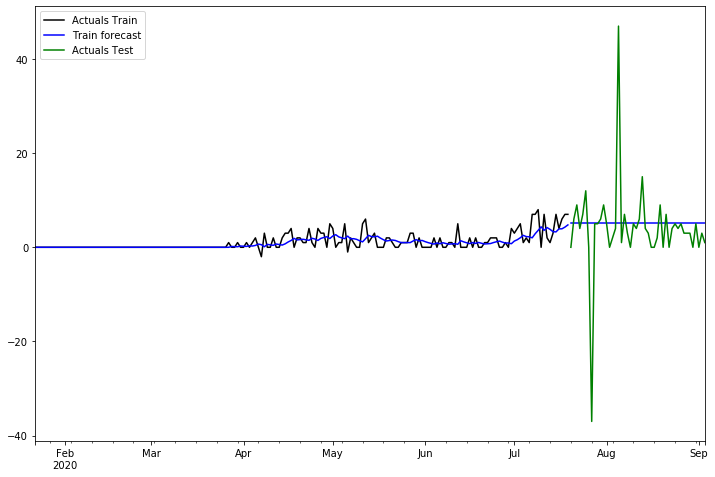

RMSE: 9.406288


C:\Users\aparna\anaconda3\lib\site-packages\statsmodels\tsa\holtwinters.py:731: RuntimeWarning: invalid value encountered in greater_equal
  loc = initial_p >= ub
C:\Users\aparna\anaconda3\lib\site-packages\statsmodels\tsa\holtwinters.py:744: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  ConvergenceWarning)


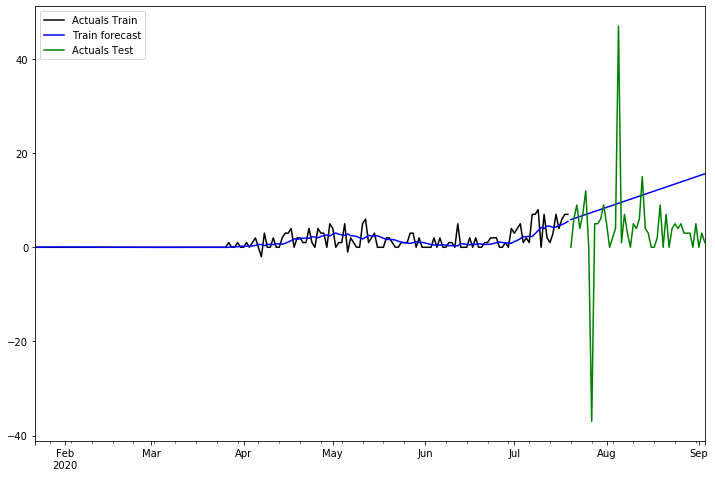

RMSE: 11.651647


C:\Users\aparna\anaconda3\lib\site-packages\statsmodels\tsa\holtwinters.py:731: RuntimeWarning: invalid value encountered in greater_equal
  loc = initial_p >= ub


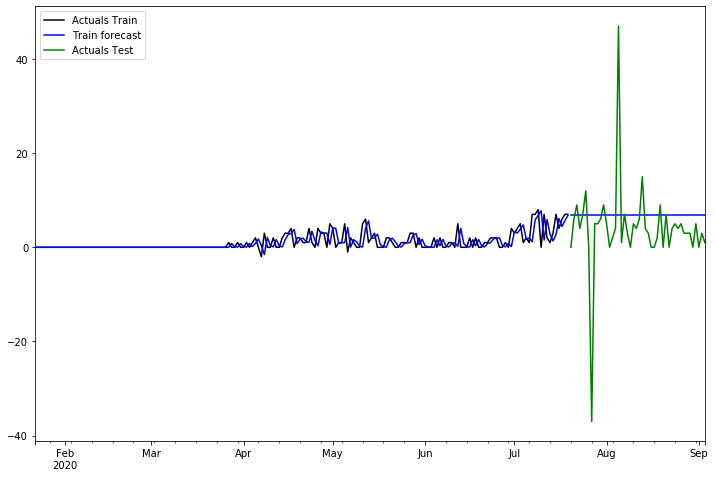

RMSE: 9.559880
Performing stepwise search to minimize aic
Fit ARIMA(7,1,7)x(0,0,0,0) [intercept=True]; AIC=644.292, BIC=695.290, Time=1.228 seconds
Fit ARIMA(0,1,0)x(0,0,0,0) [intercept=True]; AIC=746.826, BIC=753.201, Time=0.013 seconds
Fit ARIMA(1,1,0)x(0,0,0,0) [intercept=True]; AIC=703.135, BIC=712.698, Time=0.037 seconds
Fit ARIMA(0,1,1)x(0,0,0,0) [intercept=True]; AIC=655.085, BIC=664.648, Time=0.062 seconds
Fit ARIMA(0,1,0)x(0,0,0,0) [intercept=False]; AIC=744.900, BIC=748.087, Time=0.016 seconds
Fit ARIMA(6,1,7)x(0,0,0,0) [intercept=True]; AIC=641.650, BIC=689.460, Time=1.411 seconds
Near non-invertible roots for order (6, 1, 7)(0, 0, 0, 0); setting score to inf (at least one inverse root too close to the border of the unit circle: 0.997)
Fit ARIMA(7,1,6)x(0,0,0,0) [intercept=True]; AIC=647.892, BIC=695.703, Time=1.016 seconds
Fit ARIMA(8,1,7)x(0,0,0,0) [intercept=True]; AIC=647.352, BIC=701.537, Time=1.365 seconds
Near non-invertible roots for order (8, 1, 7)(0, 0, 0, 0); sett

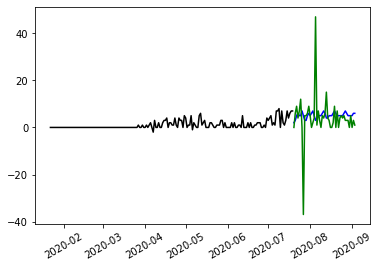

RMSE: 9.716637


In [53]:
plotTrainTestFcatSimpleExp(trainDfAND, testDfAND)
plotTrainTestFcatHolt(trainDfAND, testDfAND)
plotTrainTestFcatHoltDamped(trainDfAND, testDfAND)
plotTrainTestFcatArima(trainDfAND, testDfAND)

In [54]:
frame = {'value': texasNewDeadSeries}
texasNDDF = pd.DataFrame(frame)
texasNDDF = texasNDDF.reset_index().rename(columns={'index': 'variable'})
trainDfTND, testDfTND = getTrainTestSplit(texasNDDF, pct = 0.8)

C:\Users\aparna\anaconda3\lib\site-packages\statsmodels\tsa\holtwinters.py:731: RuntimeWarning: invalid value encountered in greater_equal
  loc = initial_p >= ub


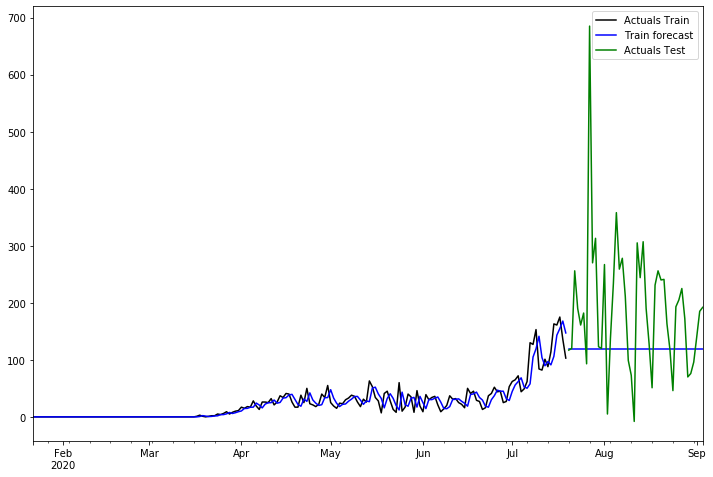

RMSE: 131.889529


C:\Users\aparna\anaconda3\lib\site-packages\statsmodels\tsa\holtwinters.py:731: RuntimeWarning: invalid value encountered in greater_equal
  loc = initial_p >= ub


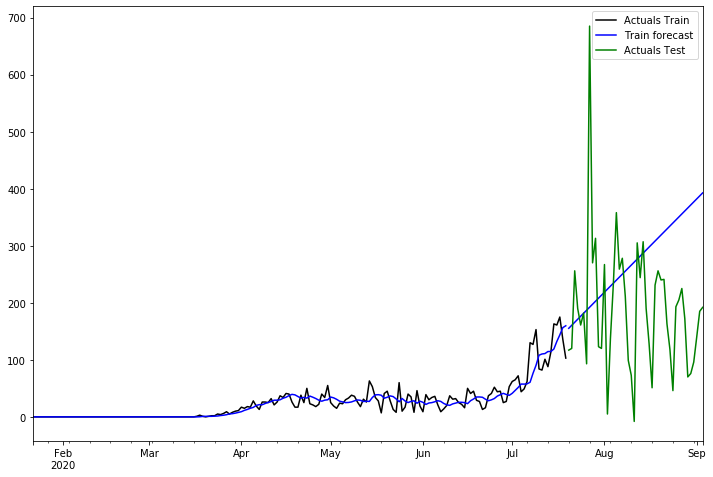

RMSE: 167.399613


C:\Users\aparna\anaconda3\lib\site-packages\statsmodels\tsa\holtwinters.py:731: RuntimeWarning: invalid value encountered in greater_equal
  loc = initial_p >= ub


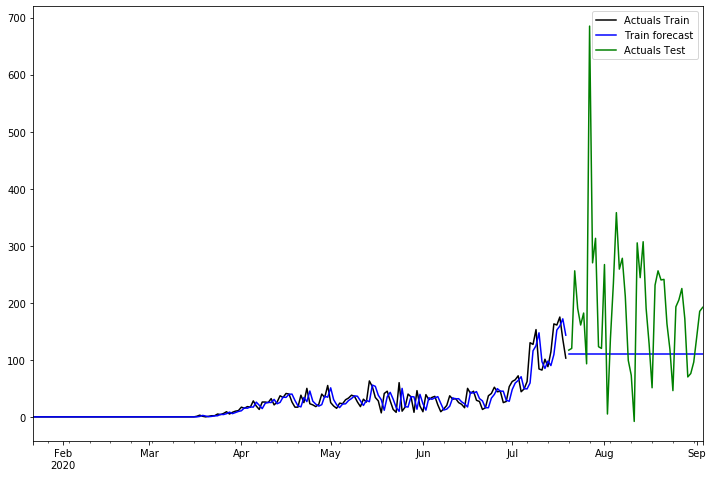

RMSE: 135.699716
Performing stepwise search to minimize aic
Fit ARIMA(7,1,7)x(0,0,0,0) [intercept=True]; AIC=1418.783, BIC=1469.781, Time=1.359 seconds
Fit ARIMA(0,1,0)x(0,0,0,0) [intercept=True]; AIC=1485.160, BIC=1491.535, Time=0.014 seconds
Fit ARIMA(1,1,0)x(0,0,0,0) [intercept=True]; AIC=1479.835, BIC=1489.397, Time=0.053 seconds
Fit ARIMA(0,1,1)x(0,0,0,0) [intercept=True]; AIC=1476.553, BIC=1486.115, Time=0.054 seconds
Fit ARIMA(0,1,0)x(0,0,0,0) [intercept=False]; AIC=1483.418, BIC=1486.605, Time=0.013 seconds
Fit ARIMA(6,1,7)x(0,0,0,0) [intercept=True]; AIC=1417.132, BIC=1464.943, Time=1.144 seconds
Fit ARIMA(5,1,7)x(0,0,0,0) [intercept=True]; AIC=1420.120, BIC=1464.743, Time=1.297 seconds
Near non-invertible roots for order (5, 1, 7)(0, 0, 0, 0); setting score to inf (at least one inverse root too close to the border of the unit circle: 0.996)
Fit ARIMA(6,1,6)x(0,0,0,0) [intercept=True]; AIC=1423.259, BIC=1467.882, Time=1.197 seconds
Near non-invertible roots for order (6, 1, 6)

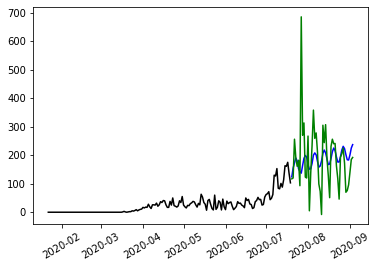

RMSE: 111.841308


In [55]:
plotTrainTestFcatSimpleExp(trainDfTND, testDfTND)
plotTrainTestFcatHolt(trainDfTND, testDfTND)
plotTrainTestFcatHoltDamped(trainDfTND, testDfTND)
plotTrainTestFcatArima(trainDfTND, testDfTND)

In [56]:
frame = {'value': usNewDeadSeries}
usNDDF = pd.DataFrame(frame)
usNDDF = usNDDF.reset_index().rename(columns={'index': 'variable'})
trainDfUSND, testDfUSND = getTrainTestSplit(usNDDF, pct = 0.8)

C:\Users\aparna\anaconda3\lib\site-packages\statsmodels\tsa\holtwinters.py:731: RuntimeWarning: invalid value encountered in greater_equal
  loc = initial_p >= ub


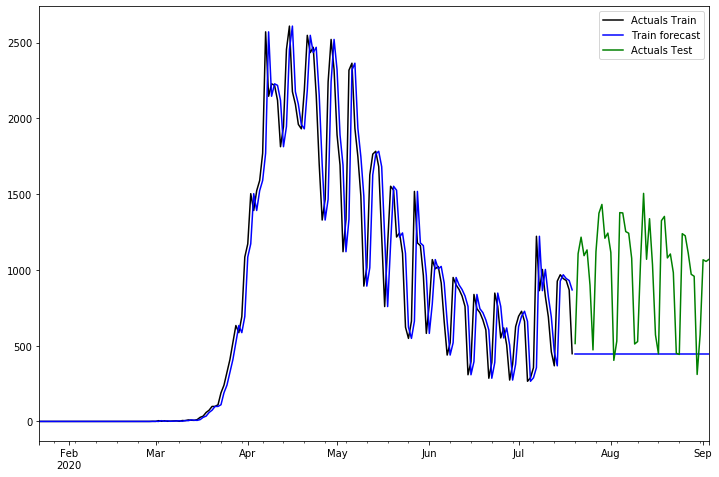

RMSE: 636.471865


C:\Users\aparna\anaconda3\lib\site-packages\statsmodels\tsa\holtwinters.py:731: RuntimeWarning: invalid value encountered in greater_equal
  loc = initial_p >= ub


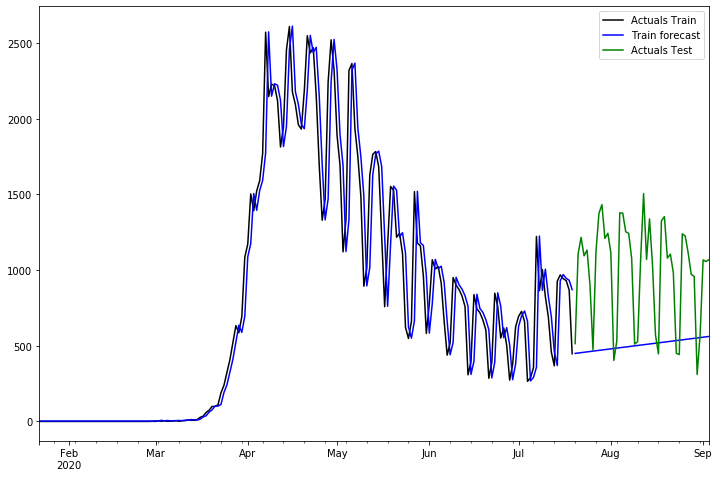

RMSE: 591.147594


C:\Users\aparna\anaconda3\lib\site-packages\statsmodels\tsa\holtwinters.py:731: RuntimeWarning: invalid value encountered in greater_equal
  loc = initial_p >= ub


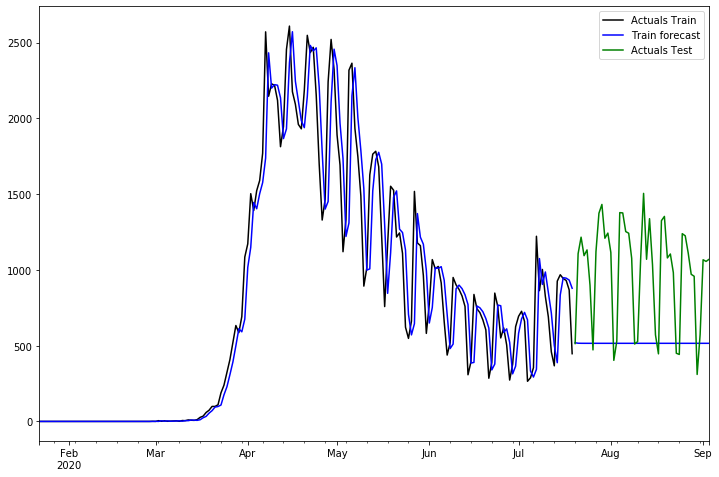

RMSE: 579.451859
Performing stepwise search to minimize aic
Fit ARIMA(7,1,7)x(0,0,0,0) [intercept=True]; AIC=2366.798, BIC=2417.796, Time=1.377 seconds
Fit ARIMA(0,1,0)x(0,0,0,0) [intercept=True]; AIC=2487.090, BIC=2493.464, Time=0.014 seconds
Fit ARIMA(1,1,0)x(0,0,0,0) [intercept=True]; AIC=2486.347, BIC=2495.909, Time=0.028 seconds
Fit ARIMA(0,1,1)x(0,0,0,0) [intercept=True]; AIC=2484.305, BIC=2493.867, Time=0.083 seconds
Fit ARIMA(0,1,0)x(0,0,0,0) [intercept=False]; AIC=2485.108, BIC=2488.296, Time=0.008 seconds
Fit ARIMA(6,1,7)x(0,0,0,0) [intercept=True]; AIC=2367.286, BIC=2415.096, Time=1.179 seconds
Fit ARIMA(7,1,6)x(0,0,0,0) [intercept=True]; AIC=2369.824, BIC=2417.635, Time=1.161 seconds
Fit ARIMA(8,1,7)x(0,0,0,0) [intercept=True]; AIC=2368.637, BIC=2422.823, Time=1.594 seconds
Fit ARIMA(7,1,8)x(0,0,0,0) [intercept=True]; AIC=2368.660, BIC=2422.846, Time=1.353 seconds
Fit ARIMA(6,1,6)x(0,0,0,0) [intercept=True]; AIC=2380.986, BIC=2425.609, Time=1.197 seconds
Fit ARIMA(6,1,8)x(0

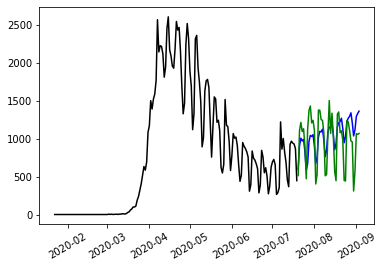

RMSE: 286.842935


In [57]:
plotTrainTestFcatSimpleExp(trainDfUSND, testDfUSND)
plotTrainTestFcatHolt(trainDfUSND, testDfUSND)
plotTrainTestFcatHoltDamped(trainDfUSND, testDfUSND)
plotTrainTestFcatArima(trainDfUSND, testDfUSND)

We also see that for new deaths in the US, the ARIMA model has the least error. Thus, we see as of September 2020, the ARIMA model is currently preferable to predict both cumulative deaths and new deaths when we consider numbers at the US level. We can expect that the total dead exceeds 200000 by October.